In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Dataset Class
class BankDataset(Dataset):
    def __init__(self, X, y, sequence_length):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X) - self.sequence_length

    def __getitem__(self, idx):
        return (self.X[idx:idx+self.sequence_length],
                self.y[idx+self.sequence_length])

In [11]:
# Bidirectional RNN Model
class BiRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, pooling_type='max'):
        super(BiRNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.birnn = nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.pooling_type = pooling_type
        # Note: doubled hidden size due to bidirectional
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        # Output shape: (batch, seq_len, 2*hidden_size)
        output, _ = self.birnn(x)

        if self.pooling_type == 'max':
            # Max pooling over sequence length
            pooled = torch.max(output, dim=1)[0]
        else:  # avg pooling
            # Average pooling over sequence length
            pooled = torch.mean(output, dim=1)

        out = self.fc(pooled)
        return out

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs, early_stopper_patience=5, device='cpu'):
    model = model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        # Validation phase
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs, y_val)
                epoch_val_loss += val_loss.item()

        # Learning rate scheduling
        scheduler.step(epoch_val_loss)

        # Early Stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopper_patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

        train_losses.append(epoch_train_loss/len(train_loader))
        val_losses.append(epoch_val_loss/len(val_loader))

        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss = {epoch_train_loss/len(train_loader):.4f}, '
                  f'Val Loss = {epoch_val_loss/len(val_loader):.4f}')

    return train_losses, val_losses

def plot_training_curves(train_losses, val_losses, params):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Training History\nParameters: {params}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [13]:
def run_experiments(X, y, device='cpu'):
    # Hyperparameters
    hidden_sizes = [32, 64, 128]
    pooling_types = ['max', 'avg']
    epochs_list = [5, 50, 100, 250, 350]
    optimizers = ['sgd', 'rmsprop', 'adam']

    # Constants
    sequence_length = 10
    input_size = X.shape[1]
    output_size = 1
    batch_size = 32

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Create datasets
    train_dataset = BankDataset(X_train, y_train, sequence_length)
    val_dataset = BankDataset(X_test, y_test, sequence_length)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    results = []

    for hidden_size in hidden_sizes:
        for pooling_type in pooling_types:
            for num_epochs in epochs_list:
                for opt_name in optimizers:
                    print(f"\nTraining BiRNN with:")
                    print(f"Hidden Size: {hidden_size}, Pooling: {pooling_type}")
                    print(f"Epochs: {num_epochs}, Optimizer: {opt_name}")

                    # Initialize model
                    model = BiRNNModel(input_size, hidden_size, output_size, pooling_type)

                    # Set optimizer
                    if opt_name == 'sgd':
                        optimizer = optim.SGD(model.parameters(), lr=0.01)
                    elif opt_name == 'rmsprop':
                        optimizer = optim.RMSprop(model.parameters(), lr=0.001)
                    else:  # adam
                        optimizer = optim.Adam(model.parameters(), lr=0.001)

                    # Loss function and scheduler
                    criterion = nn.MSELoss()
                    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer, mode='min', factor=0.1, patience=3
                    )

                    # Train model
                    train_losses, val_losses = train_model(
                        model, train_loader, val_loader,
                        criterion, optimizer, scheduler,
                        num_epochs, device=device
                    )

                    # Plot training curves
                    params = {
                        'hidden_size': hidden_size,
                        'pooling_type': pooling_type,
                        'epochs': num_epochs,
                        'optimizer': opt_name
                    }
                    plot_training_curves(train_losses, val_losses, params)

                    # Store results
                    results.append({
                        'hidden_size': hidden_size,
                        'pooling_type': pooling_type,
                        'epochs': num_epochs,
                        'optimizer': opt_name,
                        'final_train_loss': train_losses[-1],
                        'final_val_loss': val_losses[-1],
                        'best_val_loss': min(val_losses)
                    })

    return pd.DataFrame(results)

In [14]:
def analyze_results(results_df):
    # Find best configuration
    best_config = results_df.loc[results_df['best_val_loss'].idxmin()]
    print("\nBest Configuration:")
    for param, value in best_config.items():
        print(f"{param}: {value}")

    # Create comparison plots
    params = ['hidden_size', 'pooling_type', 'epochs', 'optimizer']

    for param in params:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=param, y='best_val_loss', data=results_df)
        plt.title(f'Loss Distribution by {param}')
        plt.xticks(rotation=45)
        plt.show()

        print(f"\nAnalysis by {param}:")
        analysis = results_df.groupby(param)['best_val_loss'].agg(['mean', 'std', 'min', 'max'])
        print(analysis)


In [15]:
def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Generate sample data (replace with your actual data)
    np.random.seed(42)
    n_samples = 1000
    n_features = 10
    X = np.random.randn(n_samples, n_features)
    y = np.random.randn(n_samples)

    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Run experiments
    results_df = run_experiments(X, y, device)

    # Analyze results
    analyze_results(results_df)

    # Save results
    results_df.to_csv('bank.csv', index=False)
    print("\nResults saved to 'bank.csv'")

Using device: cpu

Training BiRNN with:
Hidden Size: 32, Pooling: max
Epochs: 5, Optimizer: sgd
Epoch 0: Train Loss = 0.9293, Val Loss = 1.0265


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

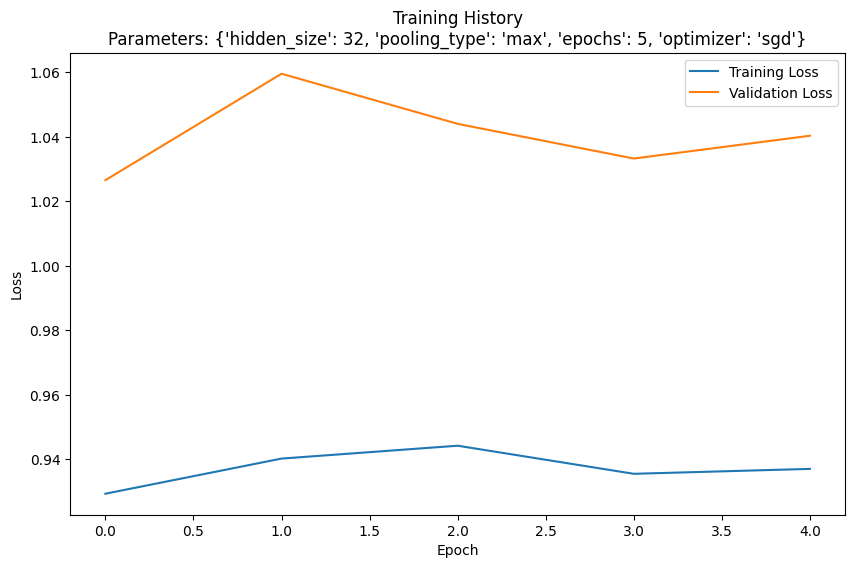


Training BiRNN with:
Hidden Size: 32, Pooling: max
Epochs: 5, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9491, Val Loss = 1.0161


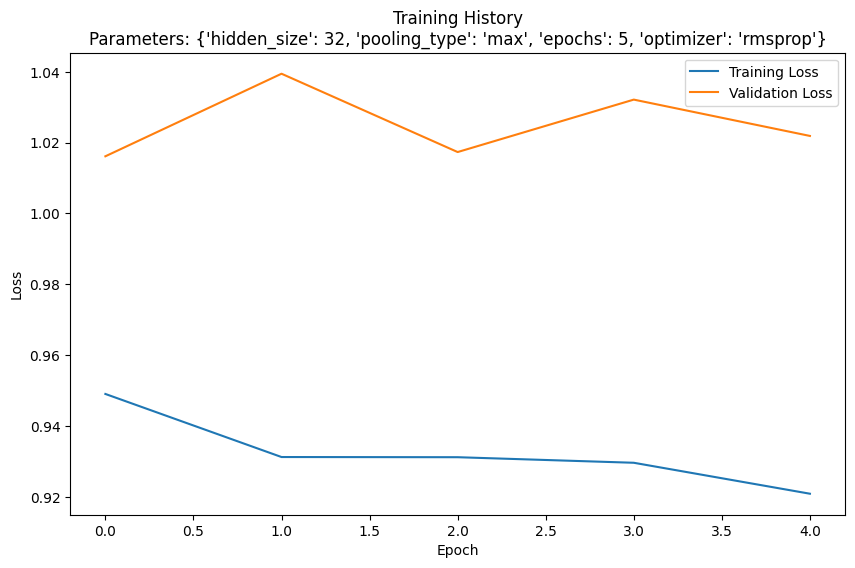


Training BiRNN with:
Hidden Size: 32, Pooling: max
Epochs: 5, Optimizer: adam
Epoch 0: Train Loss = 1.0155, Val Loss = 1.0249


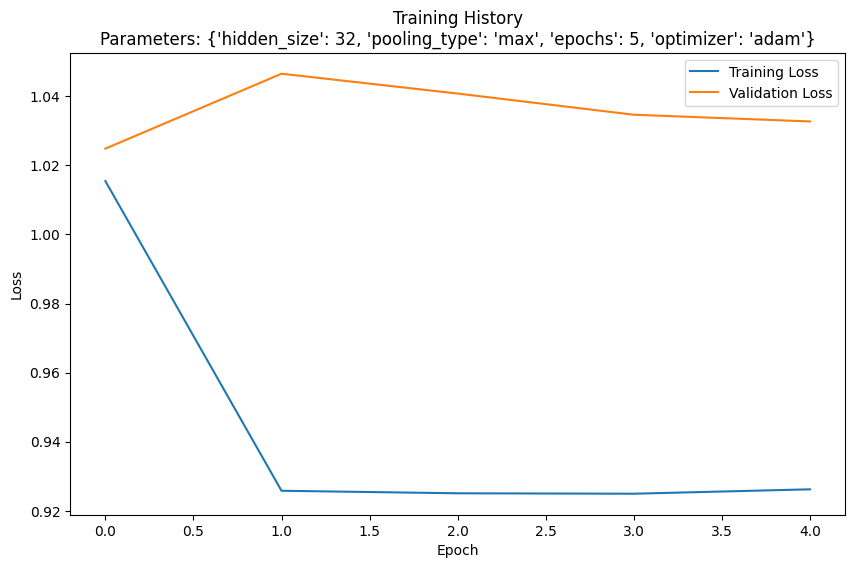


Training BiRNN with:
Hidden Size: 32, Pooling: max
Epochs: 50, Optimizer: sgd
Epoch 0: Train Loss = 0.9659, Val Loss = 1.0316
Early stopping triggered at epoch 5


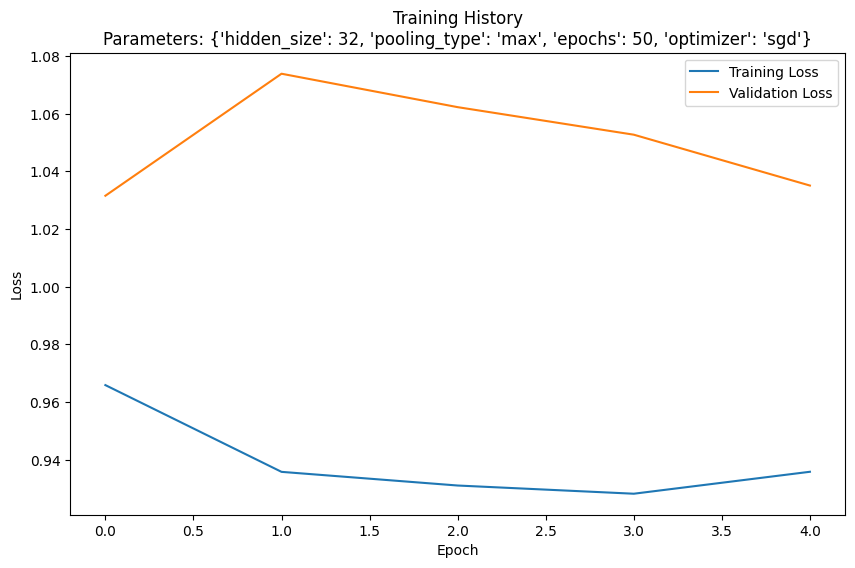


Training BiRNN with:
Hidden Size: 32, Pooling: max
Epochs: 50, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9349, Val Loss = 1.1031
Epoch 10: Train Loss = 0.9246, Val Loss = 1.0644
Early stopping triggered at epoch 12


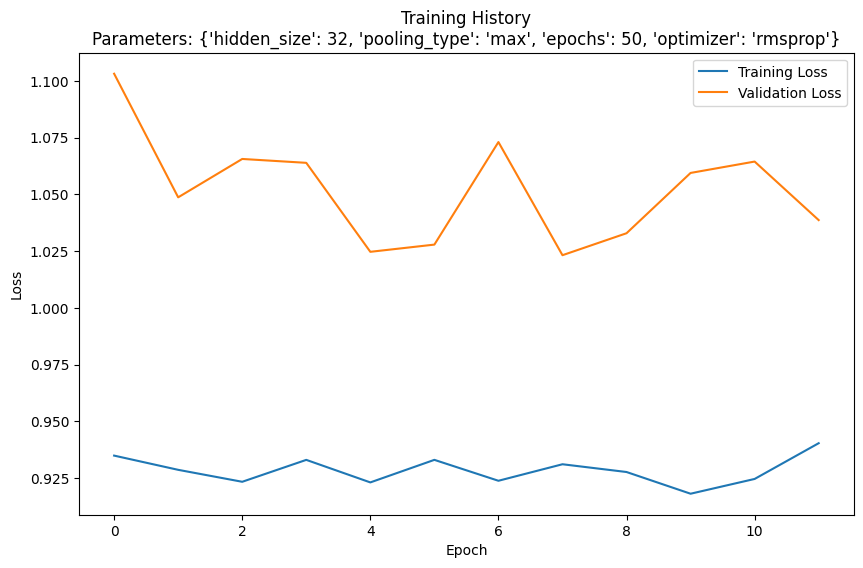


Training BiRNN with:
Hidden Size: 32, Pooling: max
Epochs: 50, Optimizer: adam
Epoch 0: Train Loss = 0.9259, Val Loss = 1.0380
Epoch 10: Train Loss = 0.9259, Val Loss = 1.0420
Early stopping triggered at epoch 11


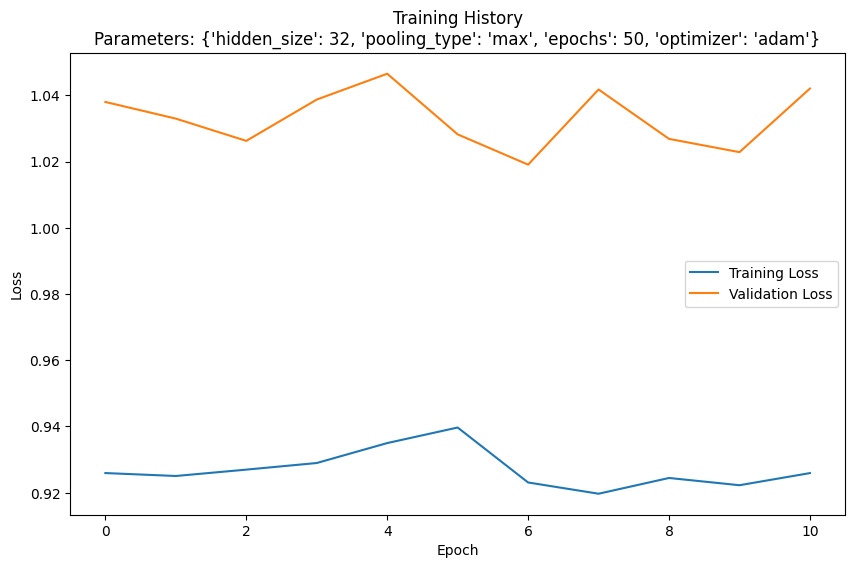


Training BiRNN with:
Hidden Size: 32, Pooling: max
Epochs: 100, Optimizer: sgd
Epoch 0: Train Loss = 0.9501, Val Loss = 1.0488
Early stopping triggered at epoch 9


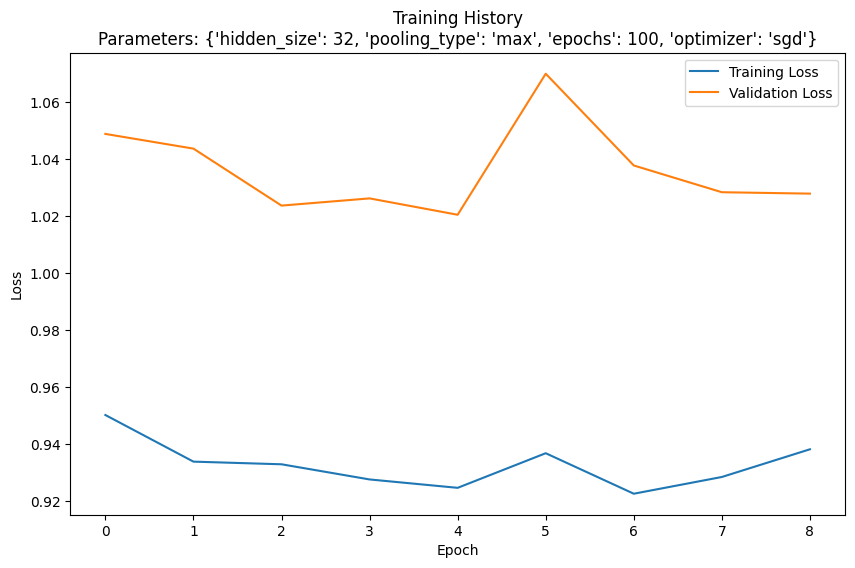


Training BiRNN with:
Hidden Size: 32, Pooling: max
Epochs: 100, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9481, Val Loss = 1.0357
Early stopping triggered at epoch 10


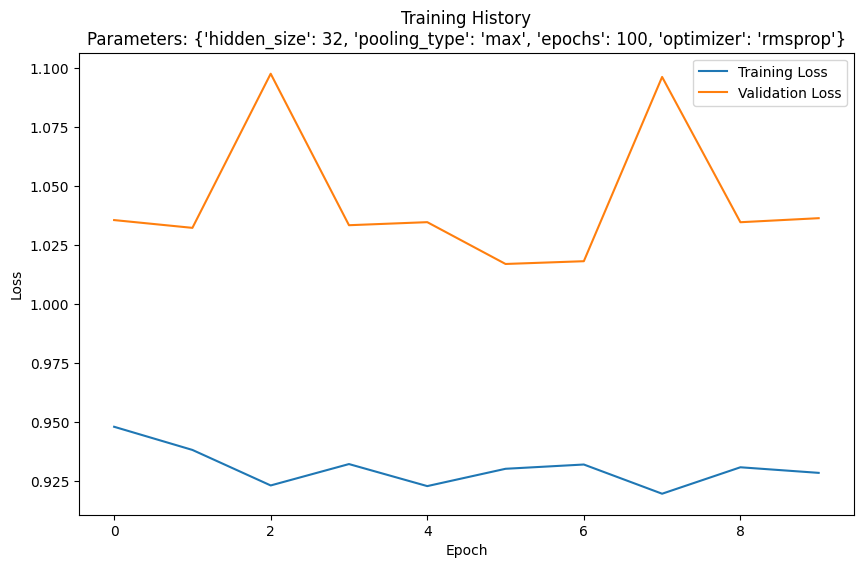


Training BiRNN with:
Hidden Size: 32, Pooling: max
Epochs: 100, Optimizer: adam
Epoch 0: Train Loss = 0.9387, Val Loss = 1.0215
Early stopping triggered at epoch 5


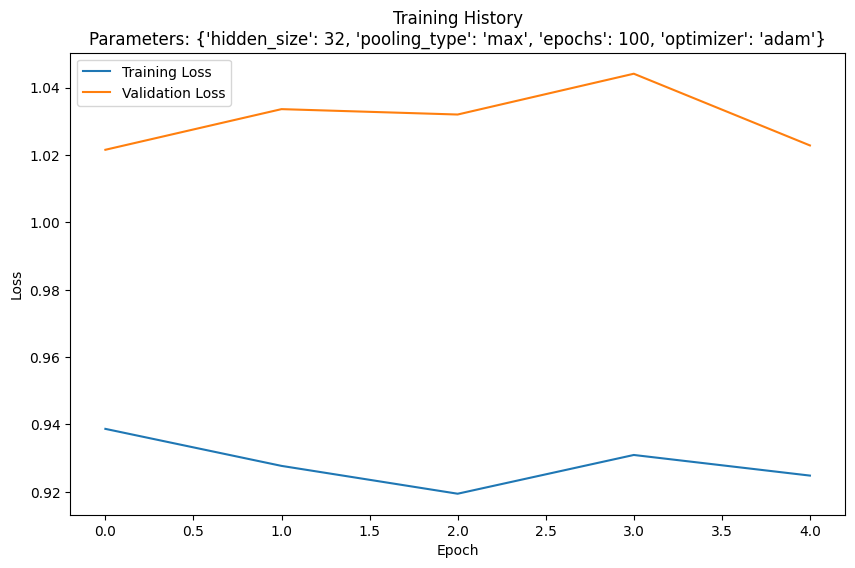


Training BiRNN with:
Hidden Size: 32, Pooling: max
Epochs: 250, Optimizer: sgd
Epoch 0: Train Loss = 0.9405, Val Loss = 1.0183
Early stopping triggered at epoch 5


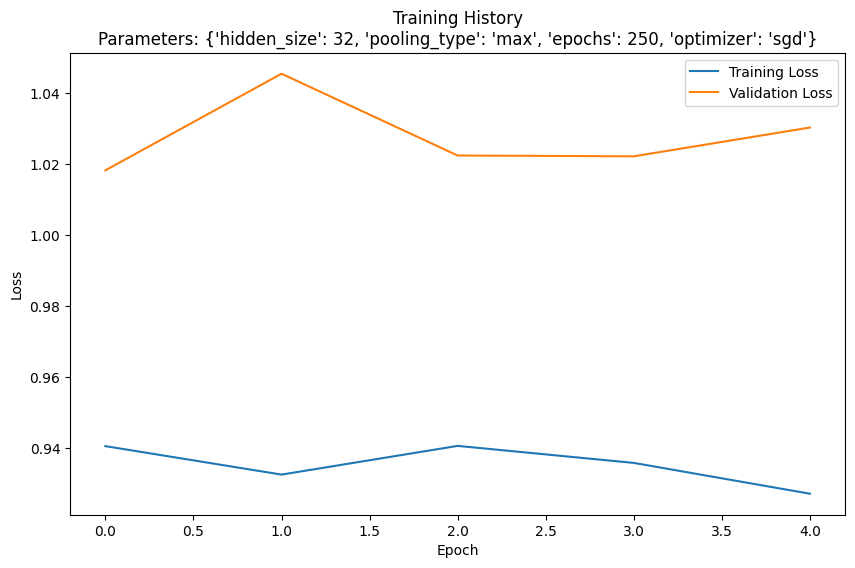


Training BiRNN with:
Hidden Size: 32, Pooling: max
Epochs: 250, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9505, Val Loss = 1.0518
Early stopping triggered at epoch 8


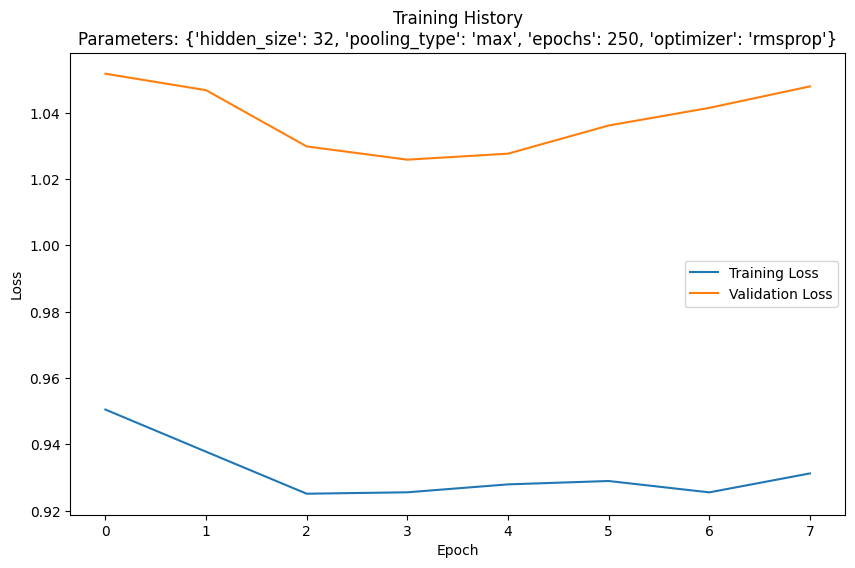


Training BiRNN with:
Hidden Size: 32, Pooling: max
Epochs: 250, Optimizer: adam
Epoch 0: Train Loss = 0.9378, Val Loss = 1.0222
Early stopping triggered at epoch 5


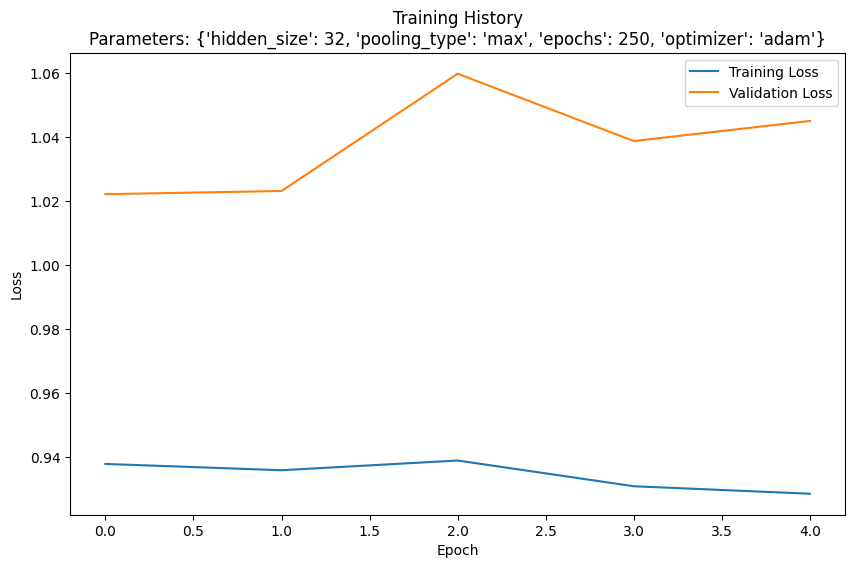


Training BiRNN with:
Hidden Size: 32, Pooling: max
Epochs: 350, Optimizer: sgd
Epoch 0: Train Loss = 0.9335, Val Loss = 1.0243
Early stopping triggered at epoch 6


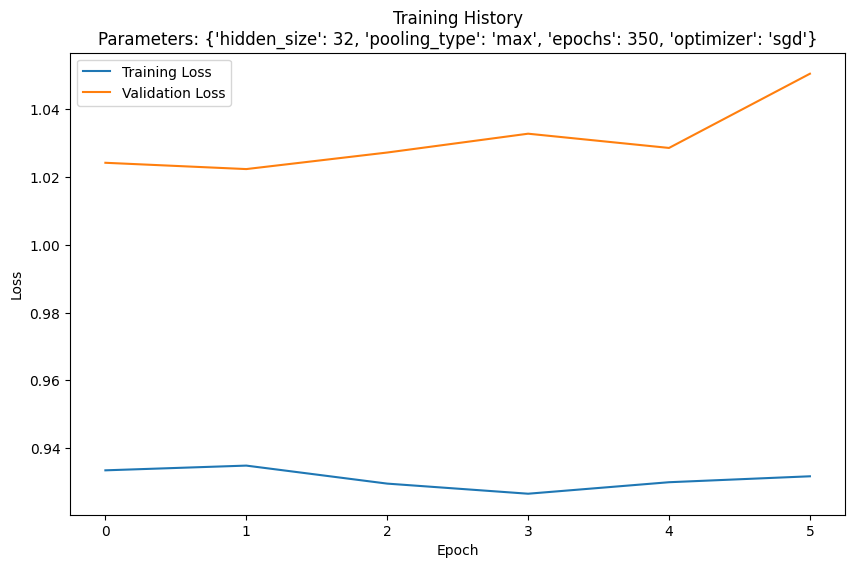


Training BiRNN with:
Hidden Size: 32, Pooling: max
Epochs: 350, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9504, Val Loss = 1.0550
Epoch 10: Train Loss = 0.9276, Val Loss = 1.0421
Early stopping triggered at epoch 11


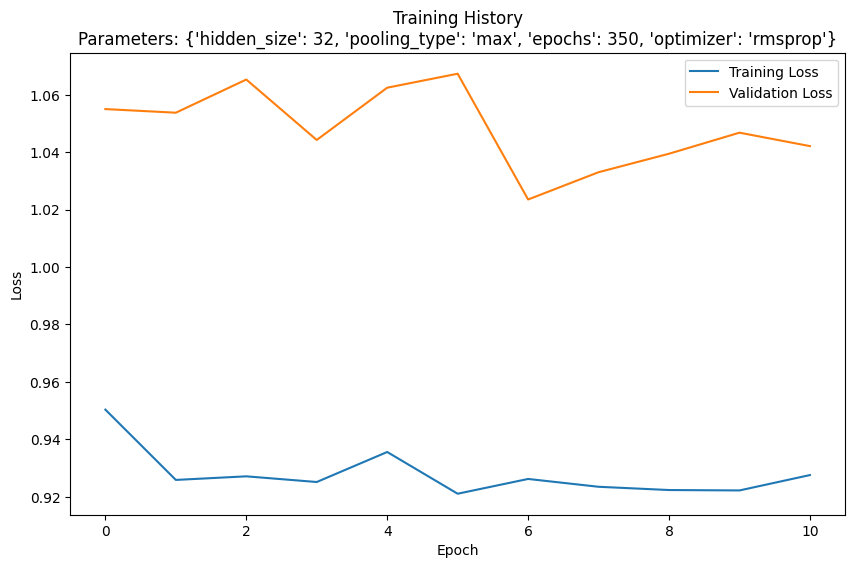


Training BiRNN with:
Hidden Size: 32, Pooling: max
Epochs: 350, Optimizer: adam
Epoch 0: Train Loss = 0.9384, Val Loss = 1.0875
Epoch 10: Train Loss = 0.9251, Val Loss = 1.0492
Early stopping triggered at epoch 13


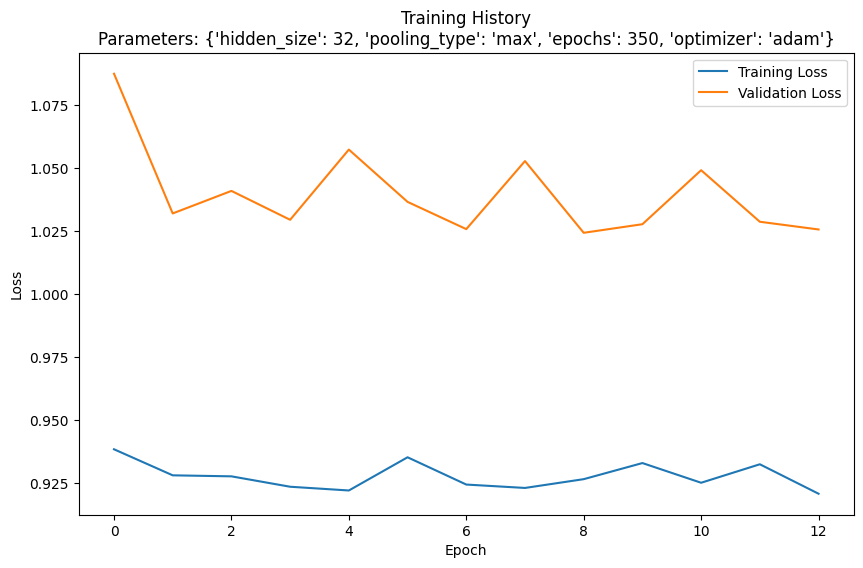


Training BiRNN with:
Hidden Size: 32, Pooling: avg
Epochs: 5, Optimizer: sgd
Epoch 0: Train Loss = 0.9290, Val Loss = 1.0205


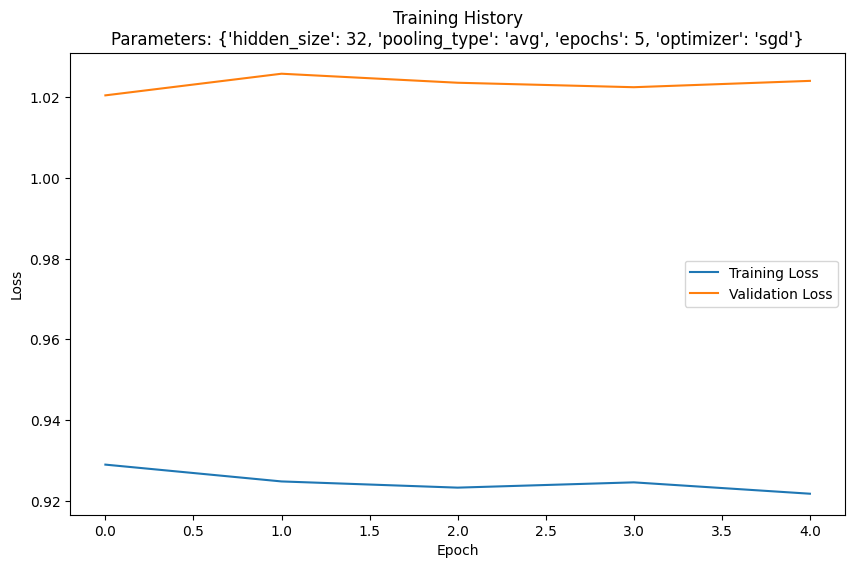


Training BiRNN with:
Hidden Size: 32, Pooling: avg
Epochs: 5, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9441, Val Loss = 1.0375


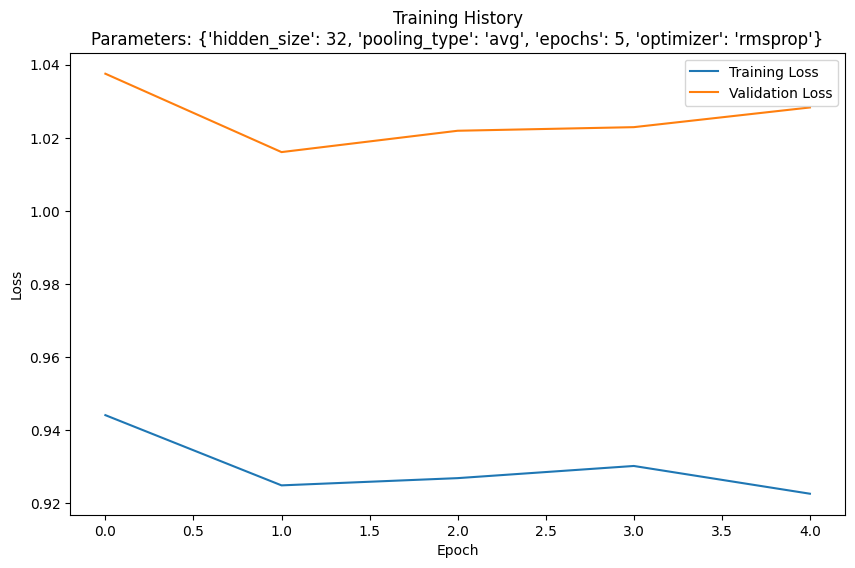


Training BiRNN with:
Hidden Size: 32, Pooling: avg
Epochs: 5, Optimizer: adam
Epoch 0: Train Loss = 0.9236, Val Loss = 1.0281


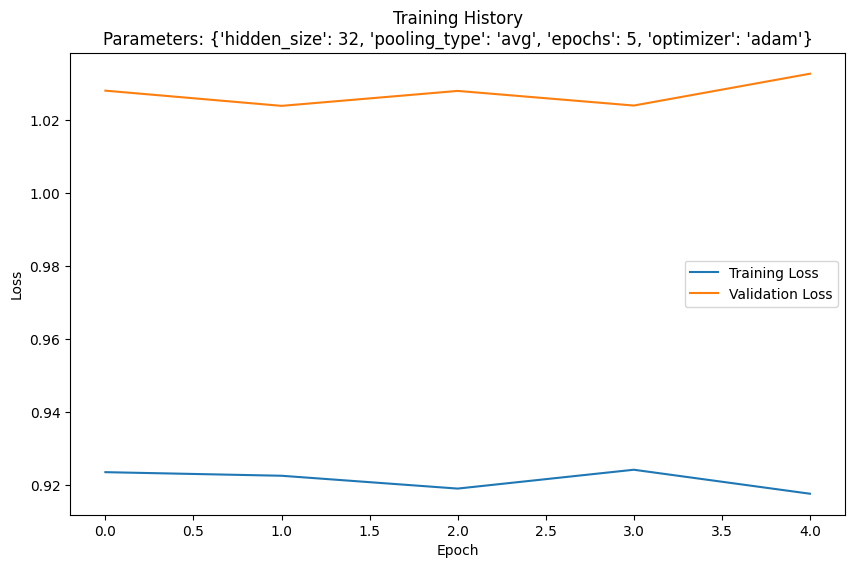


Training BiRNN with:
Hidden Size: 32, Pooling: avg
Epochs: 50, Optimizer: sgd
Epoch 0: Train Loss = 0.9285, Val Loss = 1.0340
Early stopping triggered at epoch 6


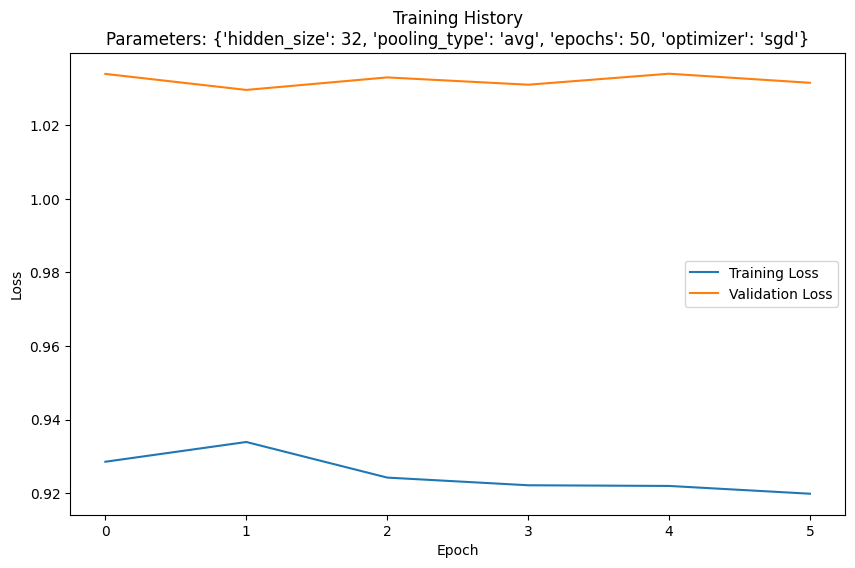


Training BiRNN with:
Hidden Size: 32, Pooling: avg
Epochs: 50, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9400, Val Loss = 1.0296
Early stopping triggered at epoch 6


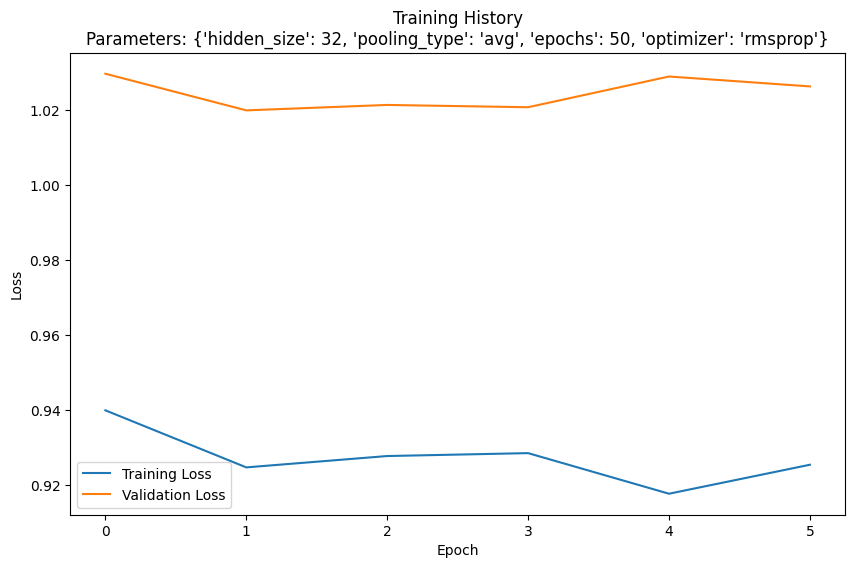


Training BiRNN with:
Hidden Size: 32, Pooling: avg
Epochs: 50, Optimizer: adam
Epoch 0: Train Loss = 0.9222, Val Loss = 1.0306
Early stopping triggered at epoch 9


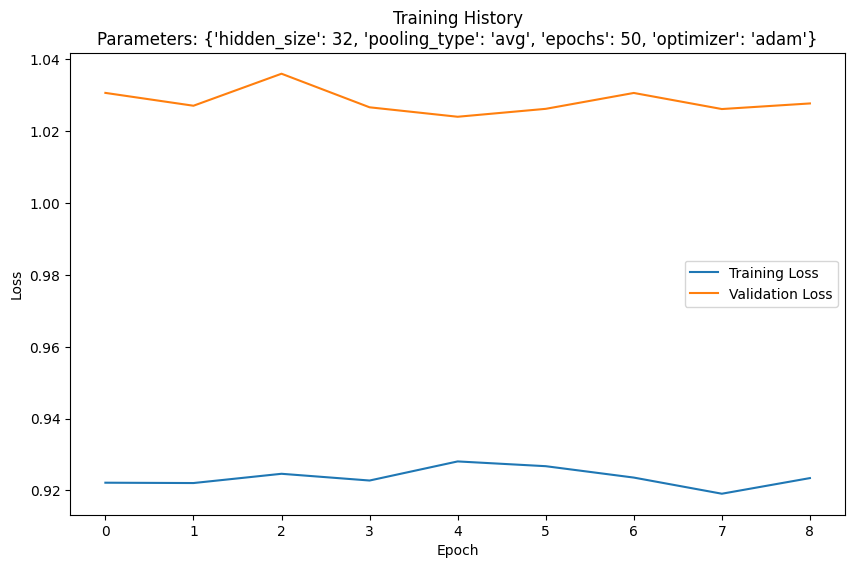


Training BiRNN with:
Hidden Size: 32, Pooling: avg
Epochs: 100, Optimizer: sgd
Epoch 0: Train Loss = 0.9244, Val Loss = 1.0279
Early stopping triggered at epoch 5


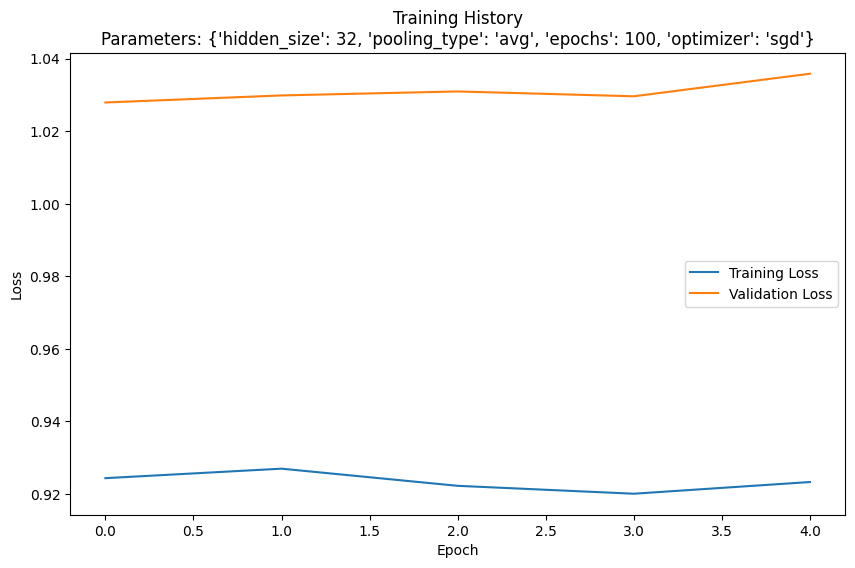


Training BiRNN with:
Hidden Size: 32, Pooling: avg
Epochs: 100, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9317, Val Loss = 1.0394
Early stopping triggered at epoch 6


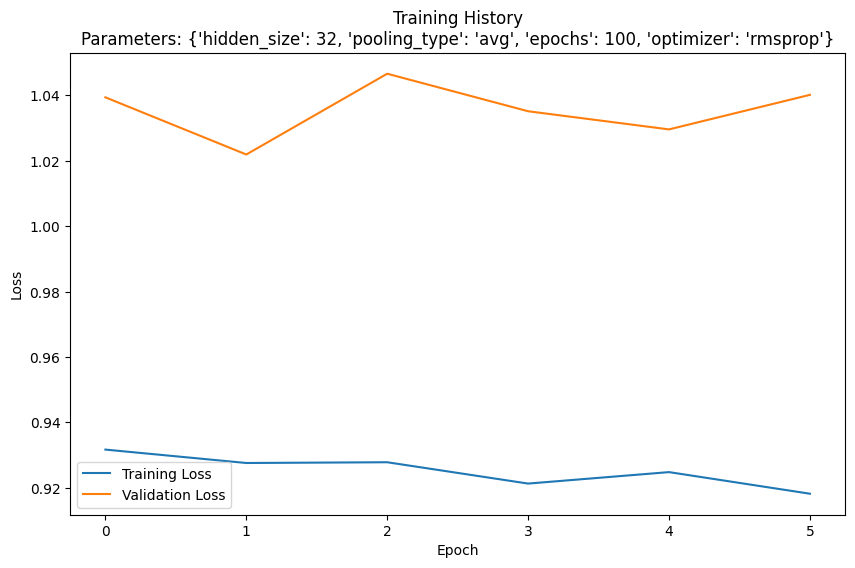


Training BiRNN with:
Hidden Size: 32, Pooling: avg
Epochs: 100, Optimizer: adam
Epoch 0: Train Loss = 0.9251, Val Loss = 1.0349
Early stopping triggered at epoch 8


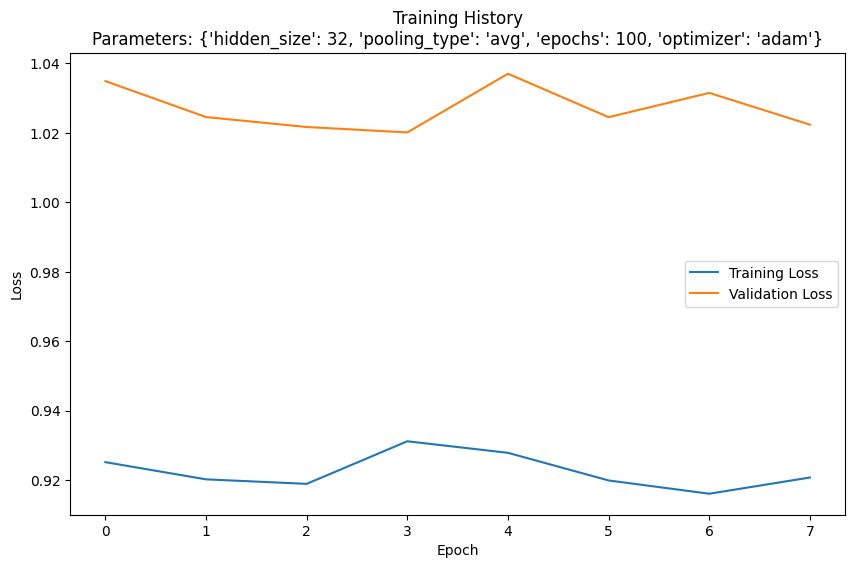


Training BiRNN with:
Hidden Size: 32, Pooling: avg
Epochs: 250, Optimizer: sgd
Epoch 0: Train Loss = 0.9269, Val Loss = 1.0245
Early stopping triggered at epoch 5


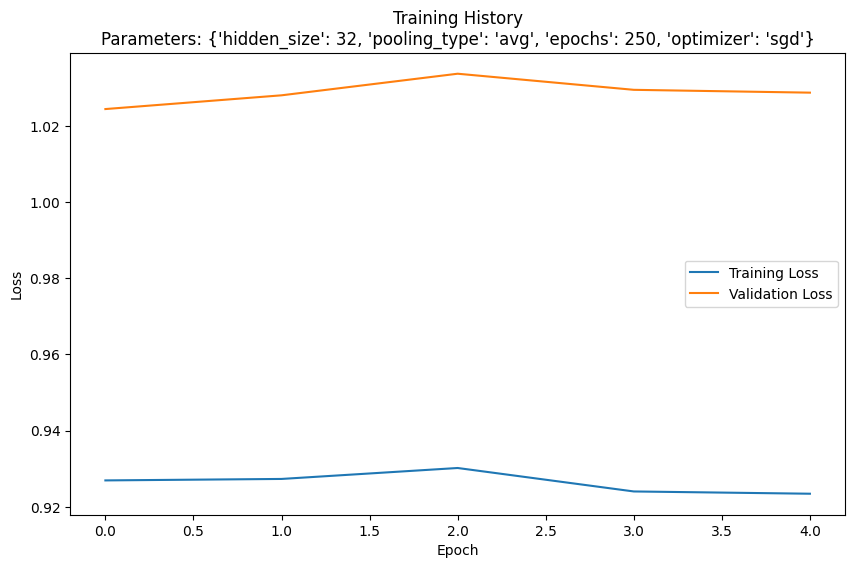


Training BiRNN with:
Hidden Size: 32, Pooling: avg
Epochs: 250, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9355, Val Loss = 1.0246
Early stopping triggered at epoch 8


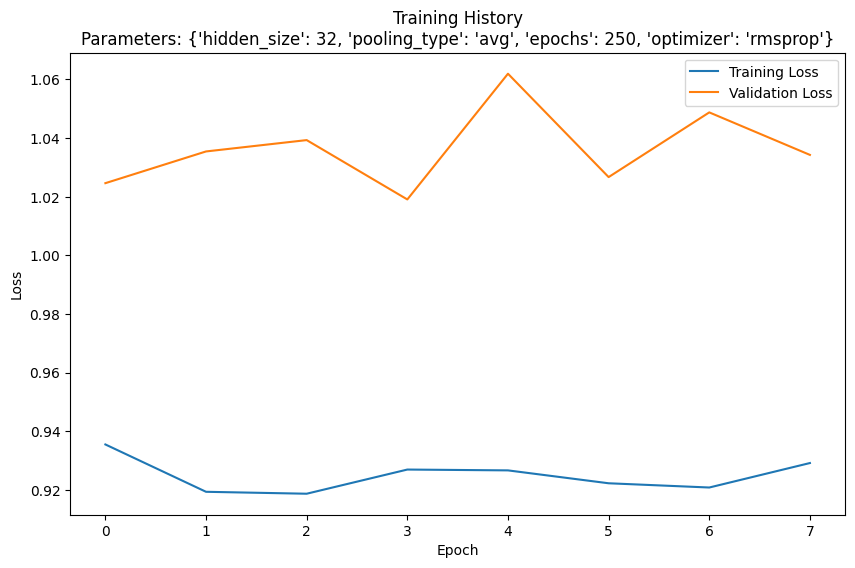


Training BiRNN with:
Hidden Size: 32, Pooling: avg
Epochs: 250, Optimizer: adam
Epoch 0: Train Loss = 0.9260, Val Loss = 1.0375
Early stopping triggered at epoch 7


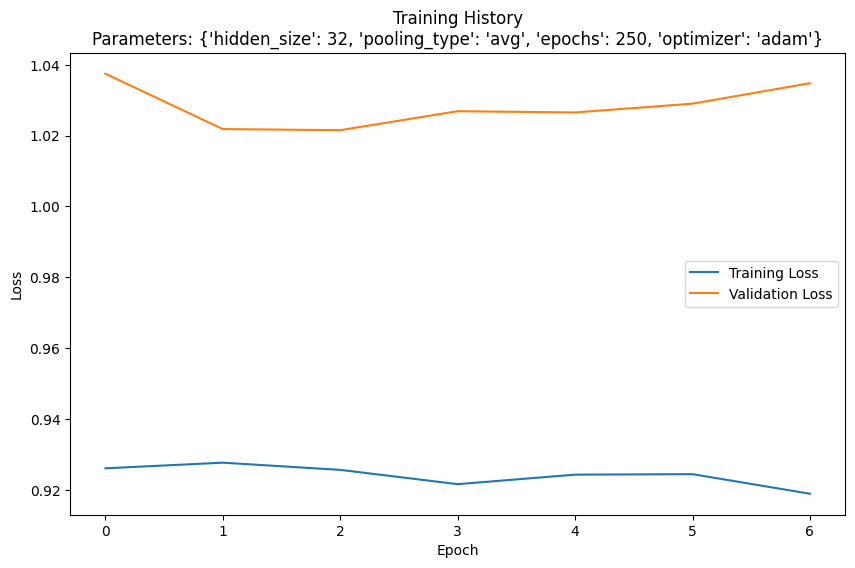


Training BiRNN with:
Hidden Size: 32, Pooling: avg
Epochs: 350, Optimizer: sgd
Epoch 0: Train Loss = 0.9357, Val Loss = 1.0231
Early stopping triggered at epoch 5


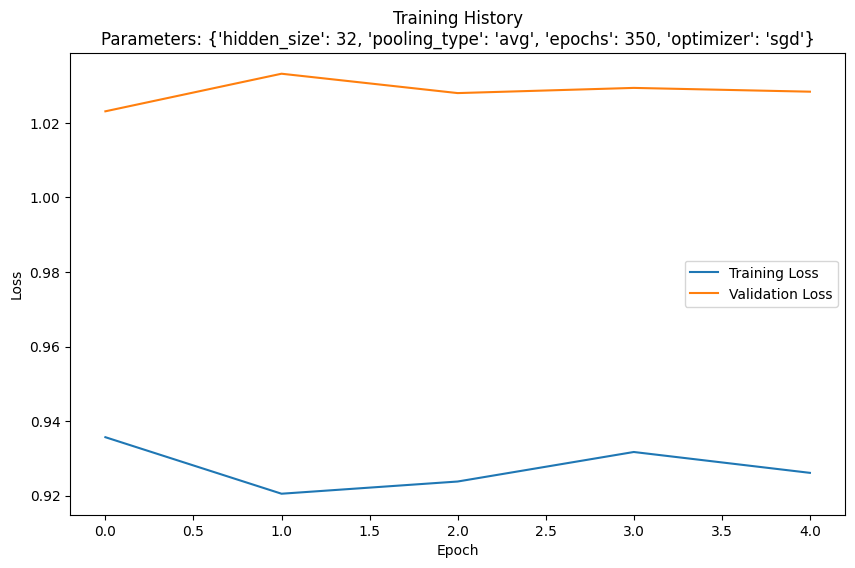


Training BiRNN with:
Hidden Size: 32, Pooling: avg
Epochs: 350, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9304, Val Loss = 1.0157
Early stopping triggered at epoch 5


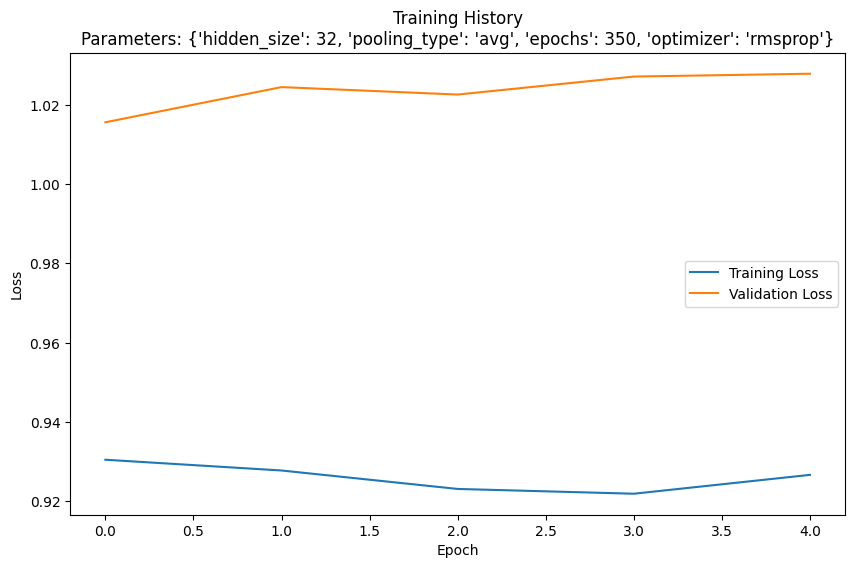


Training BiRNN with:
Hidden Size: 32, Pooling: avg
Epochs: 350, Optimizer: adam
Epoch 0: Train Loss = 0.9248, Val Loss = 1.0381
Early stopping triggered at epoch 6


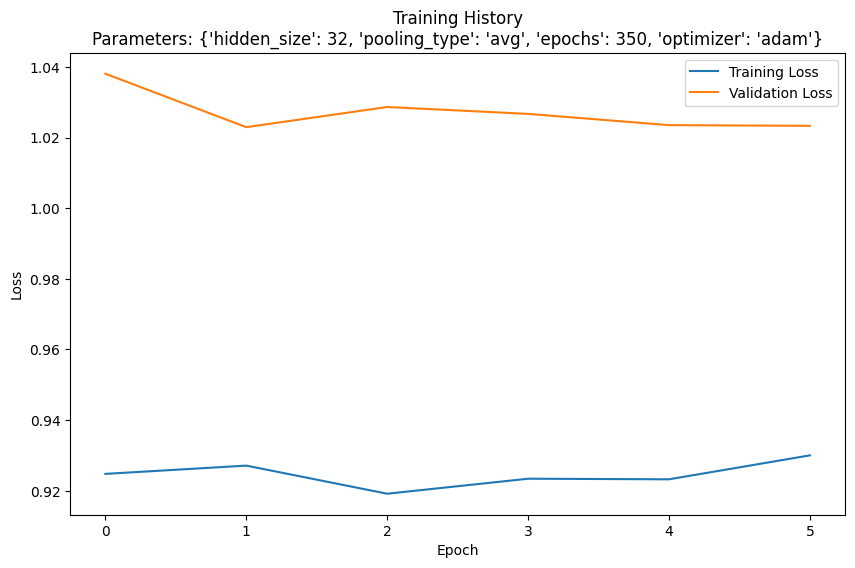


Training BiRNN with:
Hidden Size: 64, Pooling: max
Epochs: 5, Optimizer: sgd
Epoch 0: Train Loss = 0.9334, Val Loss = 1.0823


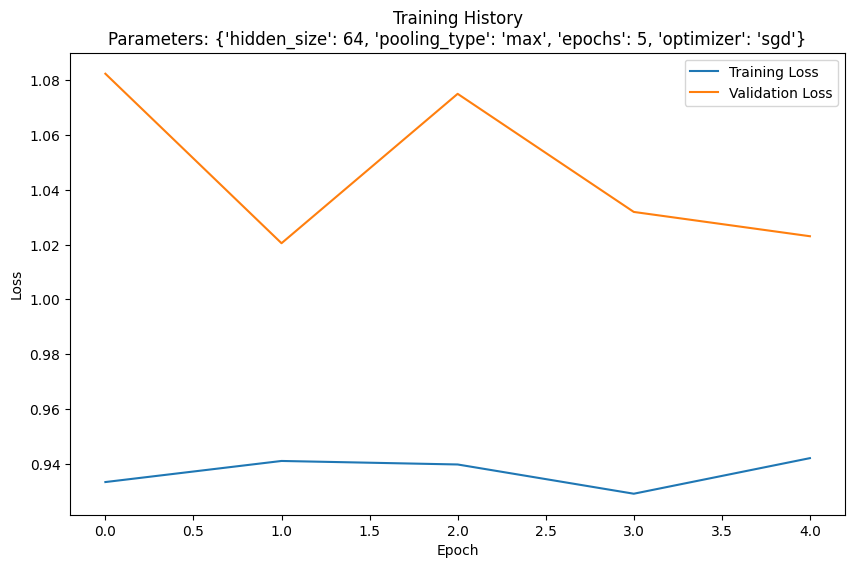


Training BiRNN with:
Hidden Size: 64, Pooling: max
Epochs: 5, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9699, Val Loss = 1.0198


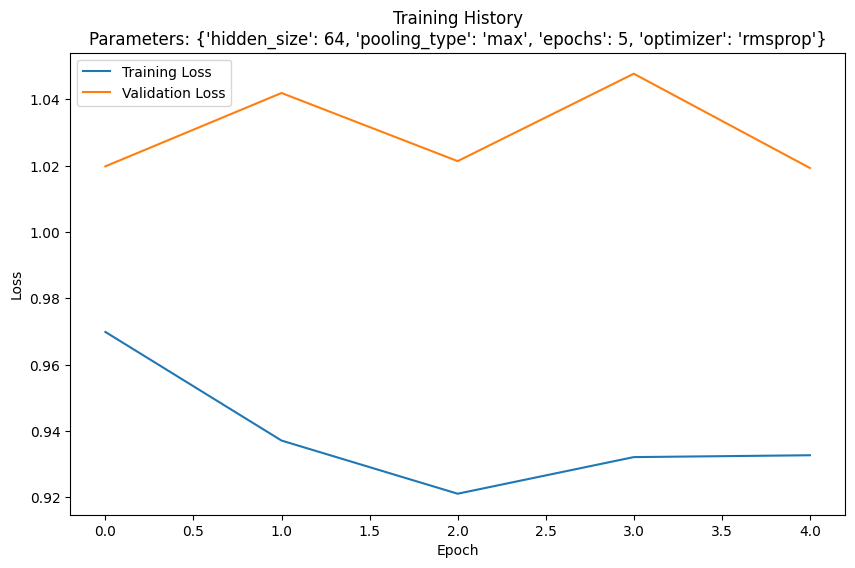


Training BiRNN with:
Hidden Size: 64, Pooling: max
Epochs: 5, Optimizer: adam
Epoch 0: Train Loss = 0.9472, Val Loss = 1.0749


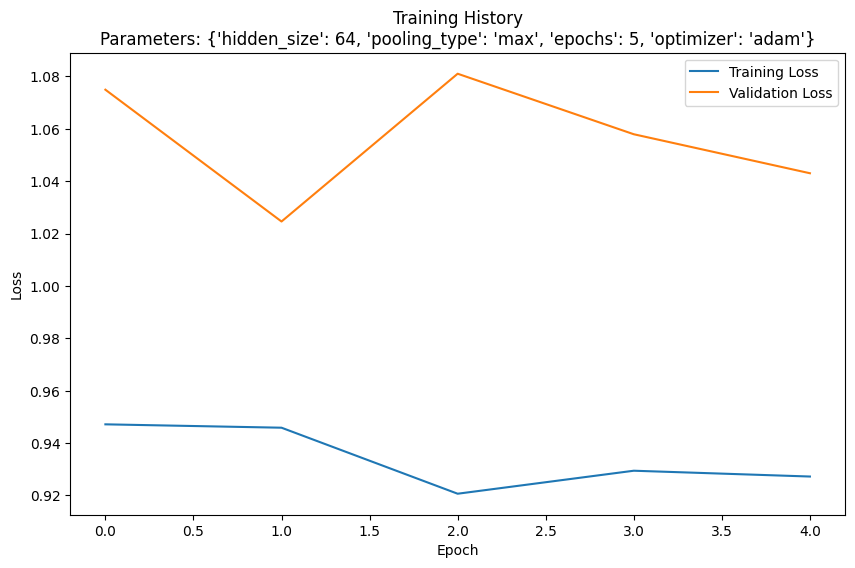


Training BiRNN with:
Hidden Size: 64, Pooling: max
Epochs: 50, Optimizer: sgd
Epoch 0: Train Loss = 0.9516, Val Loss = 1.0294
Epoch 10: Train Loss = 0.9280, Val Loss = 1.0187
Early stopping triggered at epoch 11


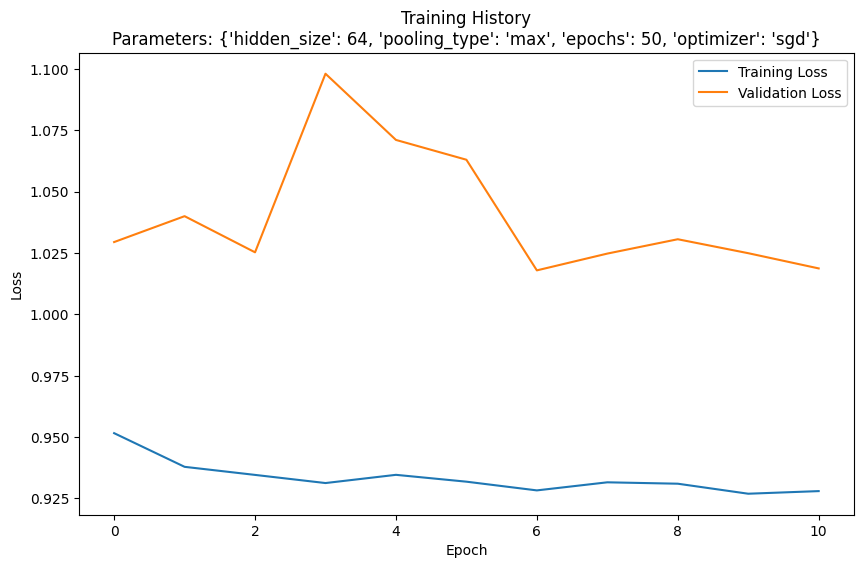


Training BiRNN with:
Hidden Size: 64, Pooling: max
Epochs: 50, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9749, Val Loss = 1.0381
Epoch 10: Train Loss = 0.9307, Val Loss = 1.0210
Early stopping triggered at epoch 13


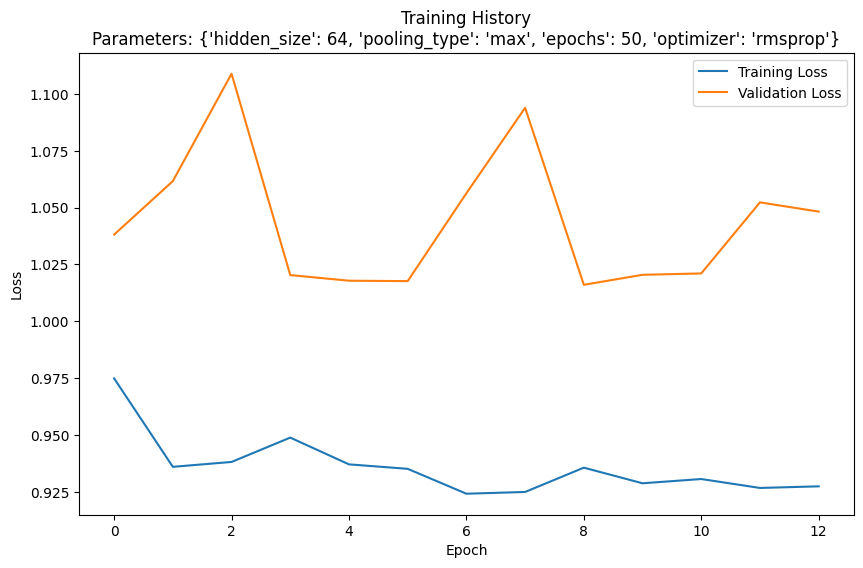


Training BiRNN with:
Hidden Size: 64, Pooling: max
Epochs: 50, Optimizer: adam
Epoch 0: Train Loss = 0.9360, Val Loss = 1.0373
Epoch 10: Train Loss = 0.9288, Val Loss = 1.0216
Early stopping triggered at epoch 14


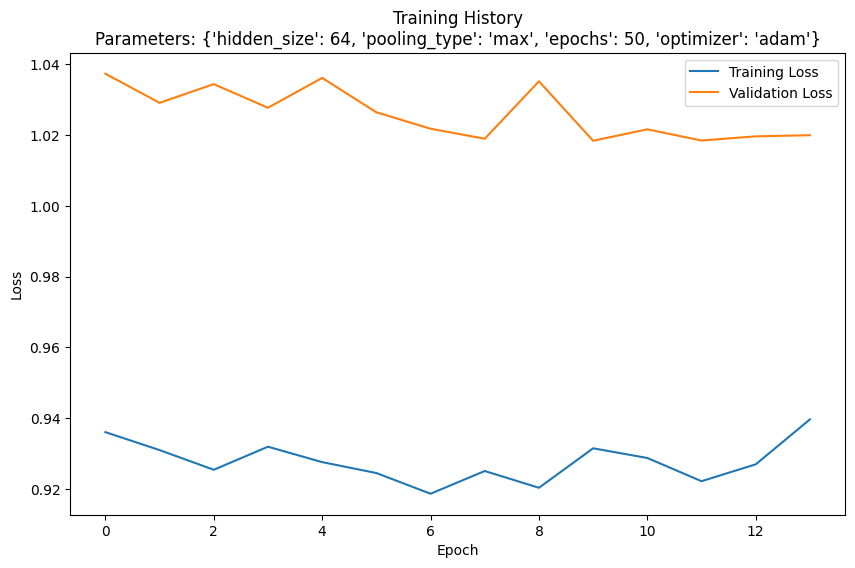


Training BiRNN with:
Hidden Size: 64, Pooling: max
Epochs: 100, Optimizer: sgd
Epoch 0: Train Loss = 0.9347, Val Loss = 1.0251
Early stopping triggered at epoch 5


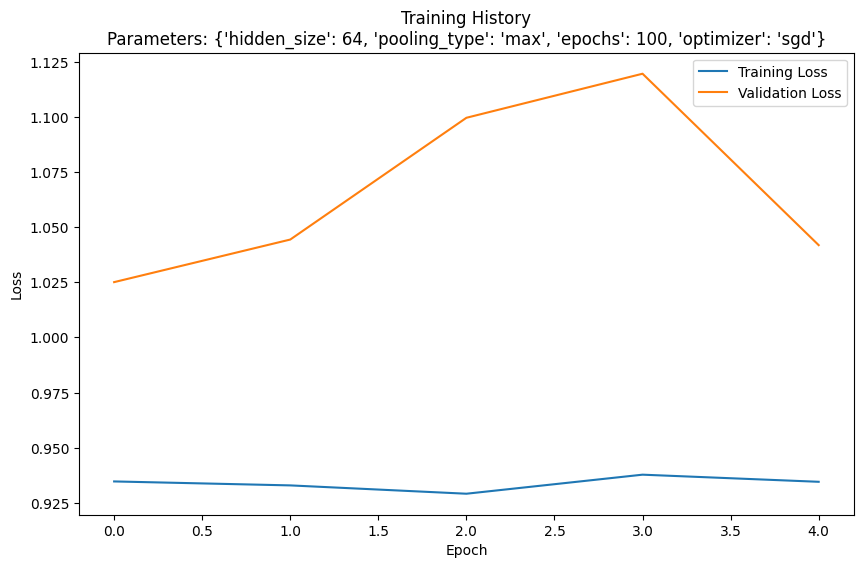


Training BiRNN with:
Hidden Size: 64, Pooling: max
Epochs: 100, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9492, Val Loss = 1.0750
Early stopping triggered at epoch 10


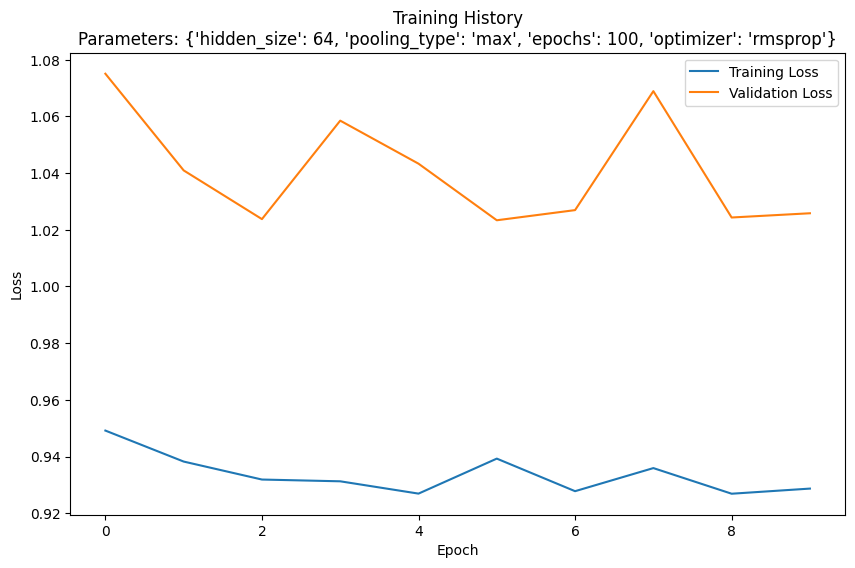


Training BiRNN with:
Hidden Size: 64, Pooling: max
Epochs: 100, Optimizer: adam
Epoch 0: Train Loss = 0.9328, Val Loss = 1.0334
Early stopping triggered at epoch 6


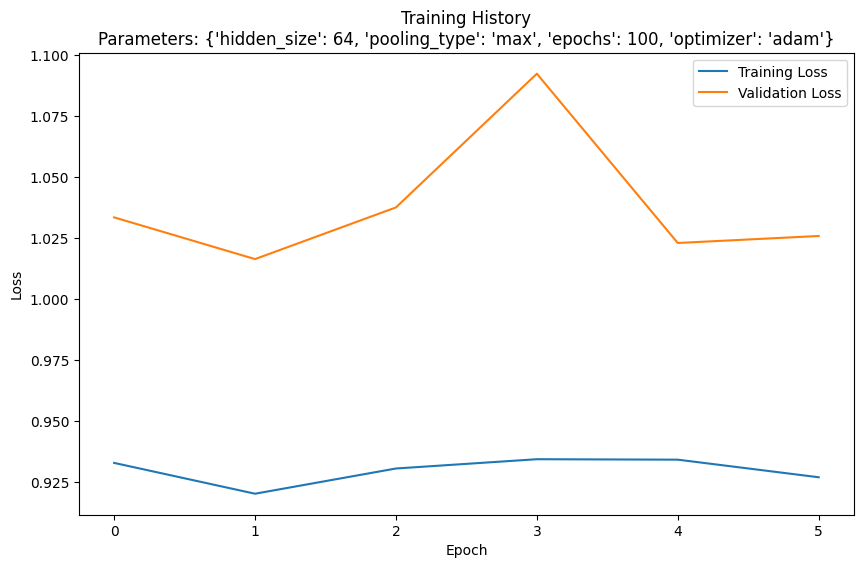


Training BiRNN with:
Hidden Size: 64, Pooling: max
Epochs: 250, Optimizer: sgd
Epoch 0: Train Loss = 0.9359, Val Loss = 1.0582
Early stopping triggered at epoch 7


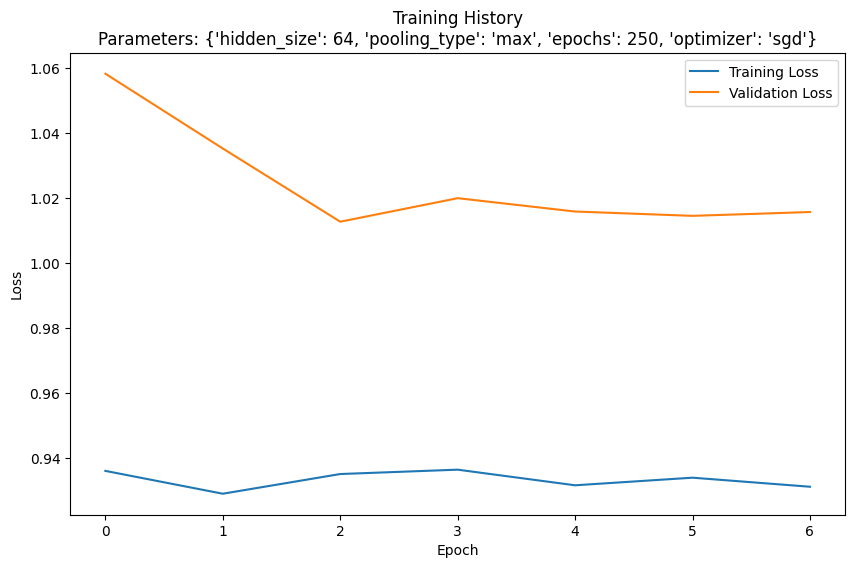


Training BiRNN with:
Hidden Size: 64, Pooling: max
Epochs: 250, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9959, Val Loss = 1.0855
Epoch 10: Train Loss = 0.9409, Val Loss = 1.0172
Early stopping triggered at epoch 15


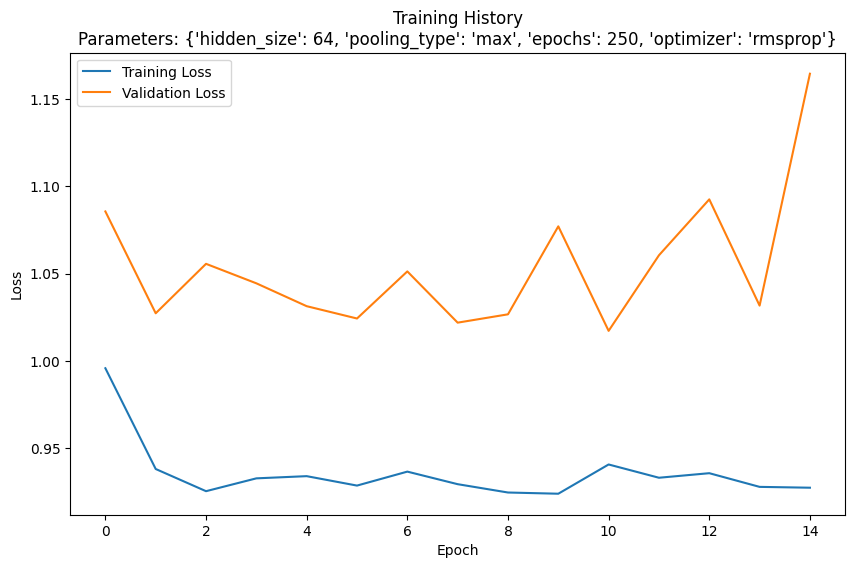


Training BiRNN with:
Hidden Size: 64, Pooling: max
Epochs: 250, Optimizer: adam
Epoch 0: Train Loss = 0.9465, Val Loss = 1.0246
Epoch 10: Train Loss = 0.9216, Val Loss = 1.0358
Early stopping triggered at epoch 16


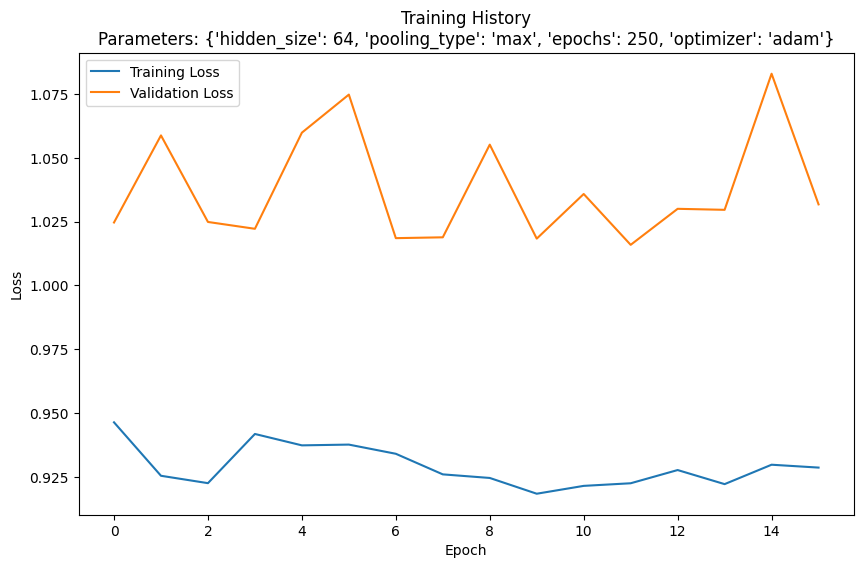


Training BiRNN with:
Hidden Size: 64, Pooling: max
Epochs: 350, Optimizer: sgd
Epoch 0: Train Loss = 0.9546, Val Loss = 1.0331
Early stopping triggered at epoch 7


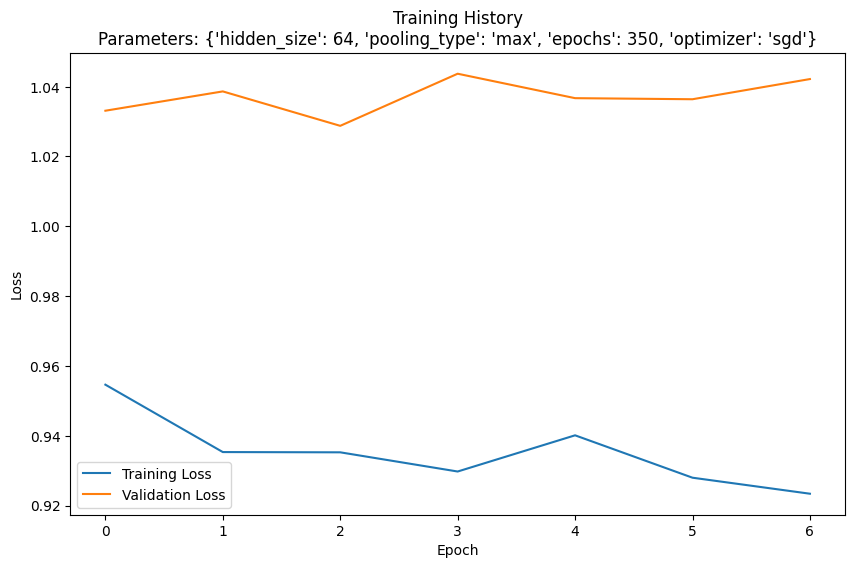


Training BiRNN with:
Hidden Size: 64, Pooling: max
Epochs: 350, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9866, Val Loss = 1.0923
Epoch 10: Train Loss = 0.9288, Val Loss = 1.0256
Early stopping triggered at epoch 11


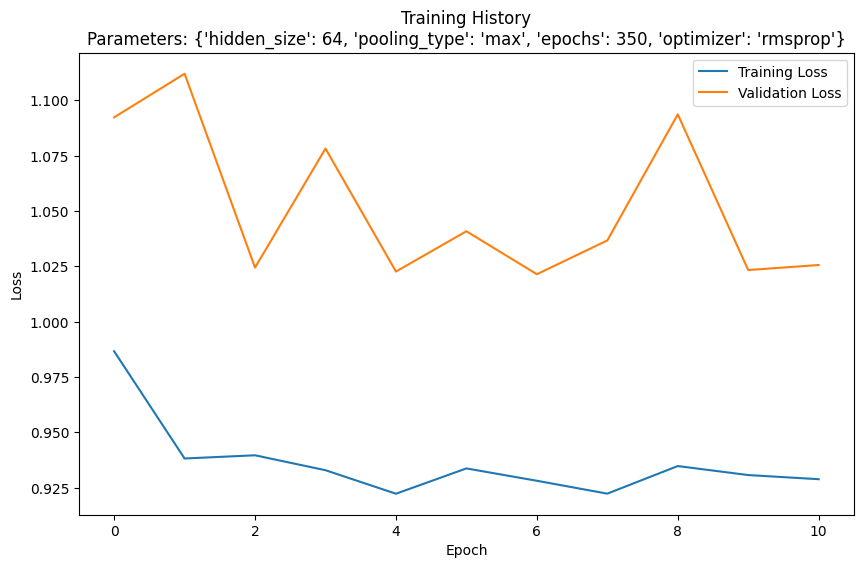


Training BiRNN with:
Hidden Size: 64, Pooling: max
Epochs: 350, Optimizer: adam
Epoch 0: Train Loss = 0.9369, Val Loss = 1.0387
Early stopping triggered at epoch 6


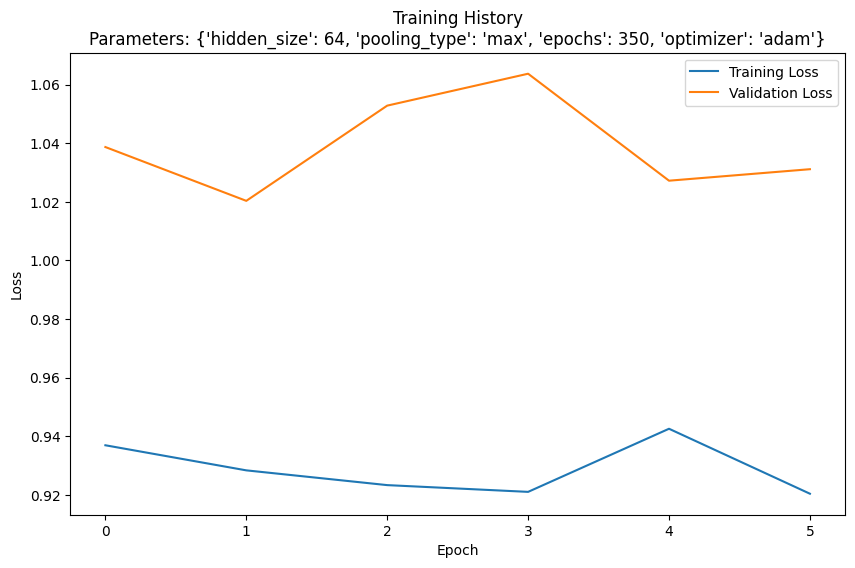


Training BiRNN with:
Hidden Size: 64, Pooling: avg
Epochs: 5, Optimizer: sgd
Epoch 0: Train Loss = 0.9255, Val Loss = 1.0200


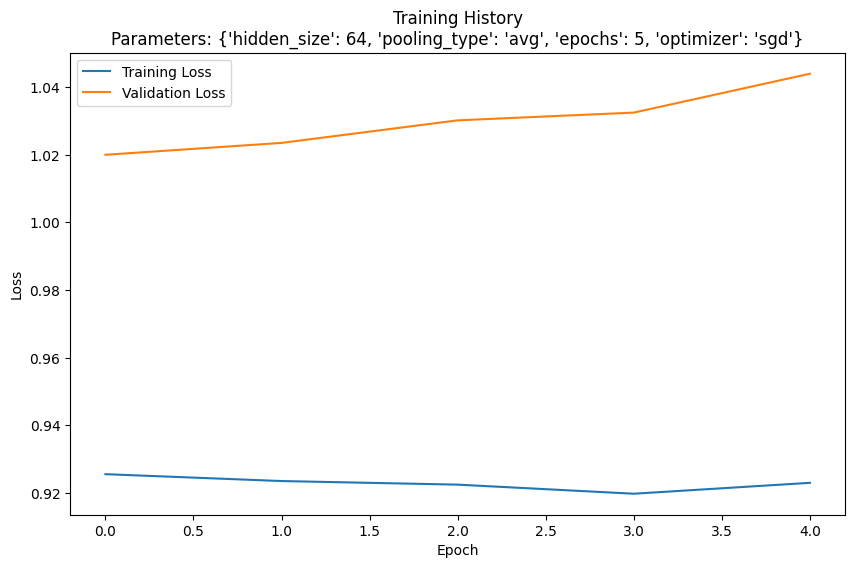


Training BiRNN with:
Hidden Size: 64, Pooling: avg
Epochs: 5, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9281, Val Loss = 1.0278


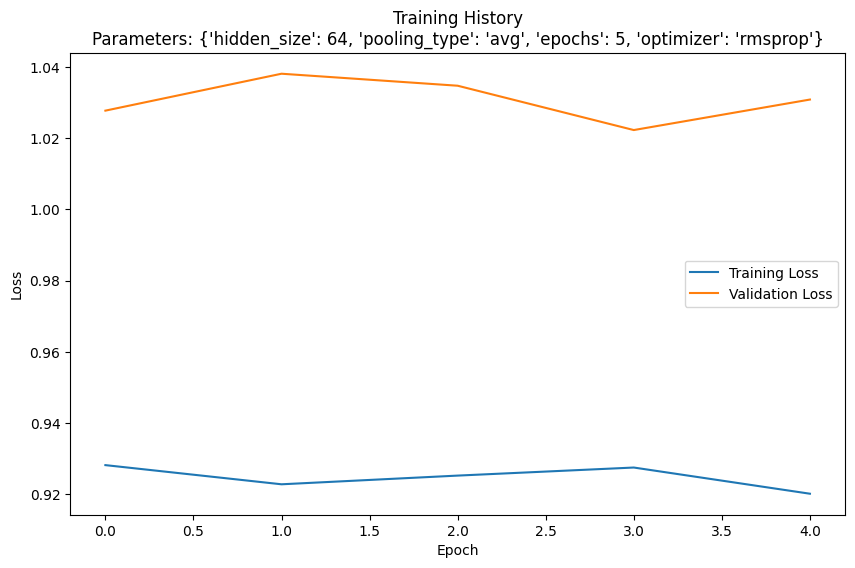


Training BiRNN with:
Hidden Size: 64, Pooling: avg
Epochs: 5, Optimizer: adam
Epoch 0: Train Loss = 0.9253, Val Loss = 1.0318


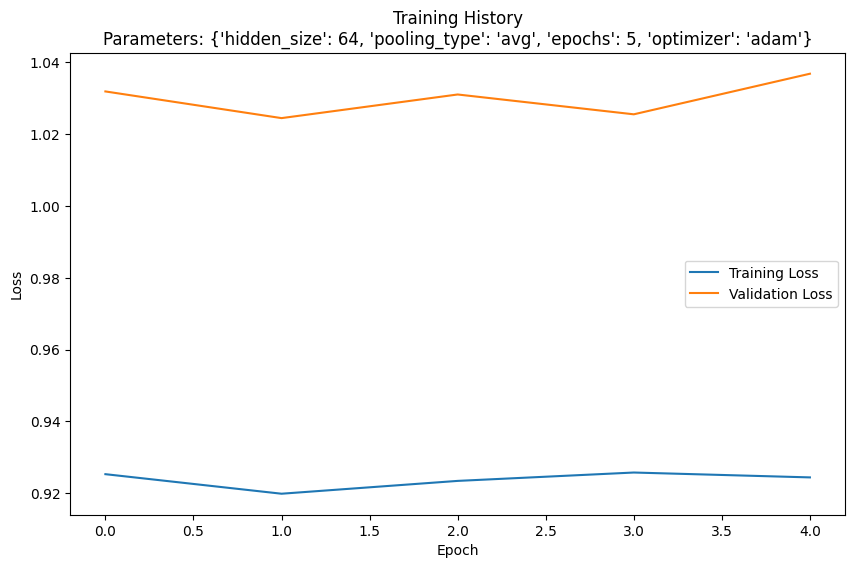


Training BiRNN with:
Hidden Size: 64, Pooling: avg
Epochs: 50, Optimizer: sgd
Epoch 0: Train Loss = 0.9322, Val Loss = 1.0212
Early stopping triggered at epoch 5


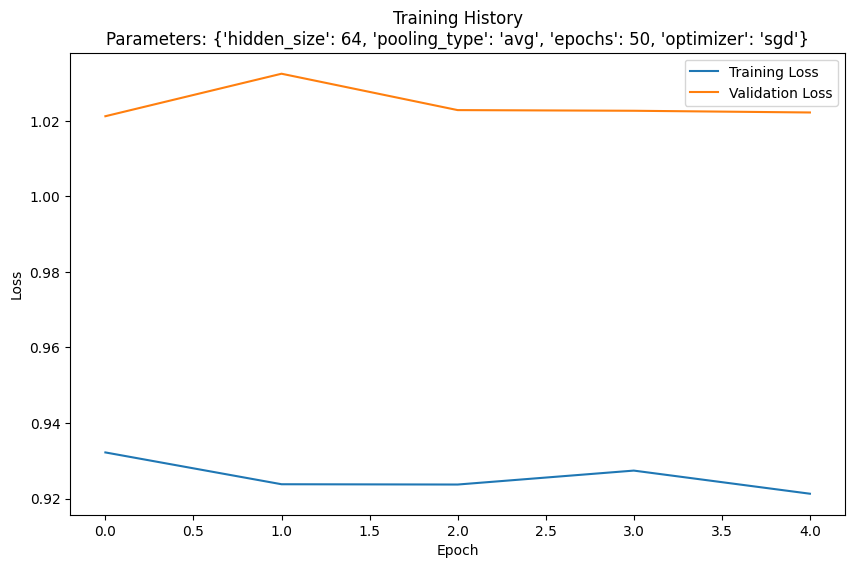


Training BiRNN with:
Hidden Size: 64, Pooling: avg
Epochs: 50, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9359, Val Loss = 1.0236
Early stopping triggered at epoch 8


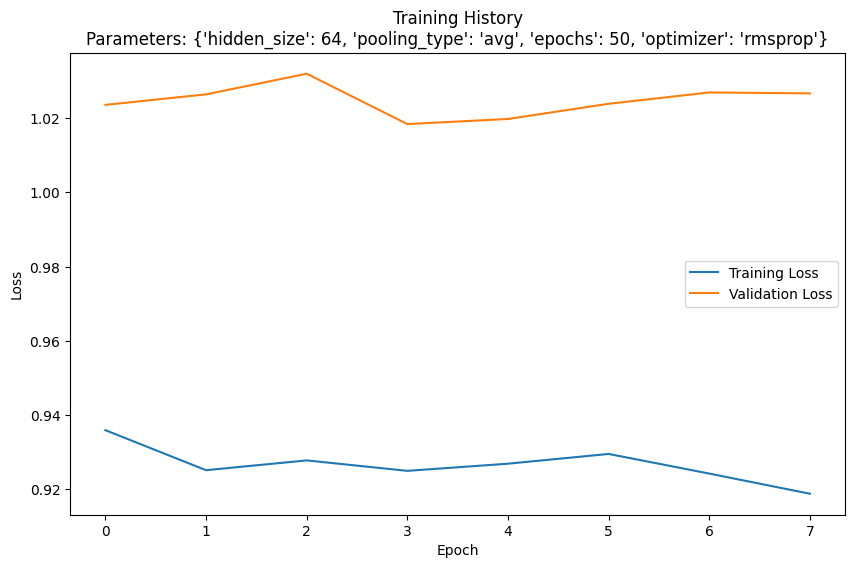


Training BiRNN with:
Hidden Size: 64, Pooling: avg
Epochs: 50, Optimizer: adam
Epoch 0: Train Loss = 0.9208, Val Loss = 1.0198
Early stopping triggered at epoch 5


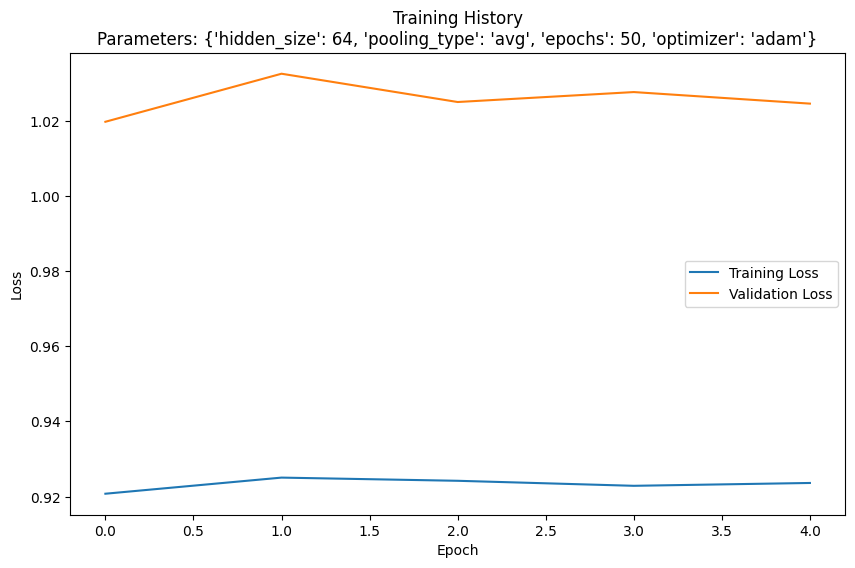


Training BiRNN with:
Hidden Size: 64, Pooling: avg
Epochs: 100, Optimizer: sgd
Epoch 0: Train Loss = 0.9269, Val Loss = 1.0233
Early stopping triggered at epoch 5


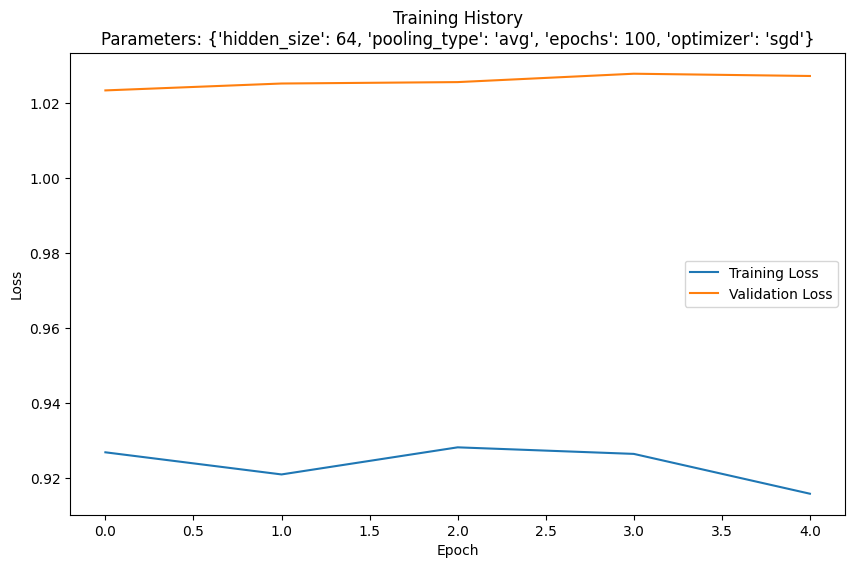


Training BiRNN with:
Hidden Size: 64, Pooling: avg
Epochs: 100, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9383, Val Loss = 1.0381
Early stopping triggered at epoch 7


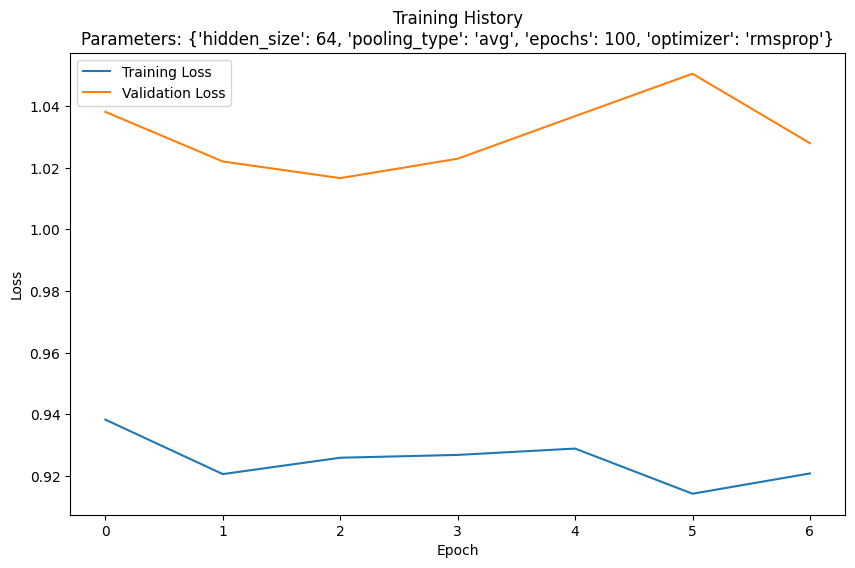


Training BiRNN with:
Hidden Size: 64, Pooling: avg
Epochs: 100, Optimizer: adam
Epoch 0: Train Loss = 0.9287, Val Loss = 1.0257
Epoch 10: Train Loss = 0.9232, Val Loss = 1.0297
Early stopping triggered at epoch 11


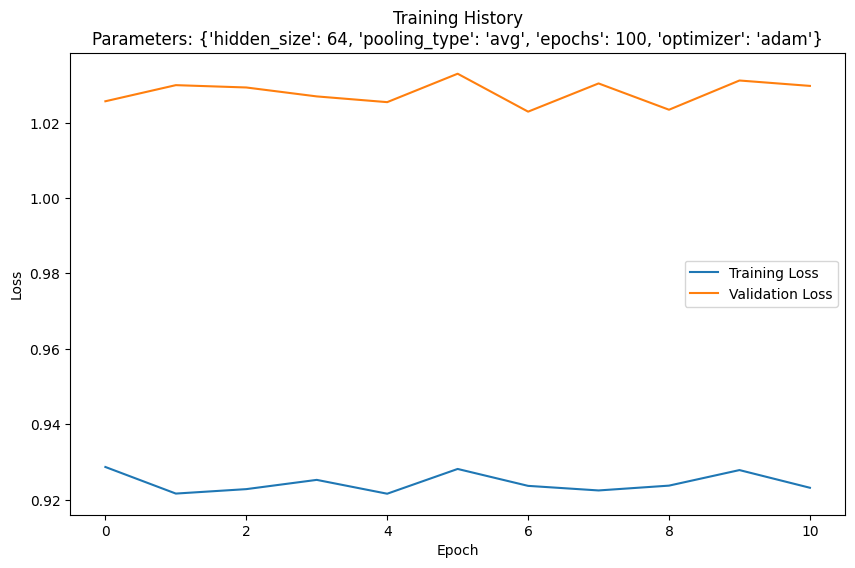


Training BiRNN with:
Hidden Size: 64, Pooling: avg
Epochs: 250, Optimizer: sgd
Epoch 0: Train Loss = 0.9270, Val Loss = 1.0260
Early stopping triggered at epoch 8


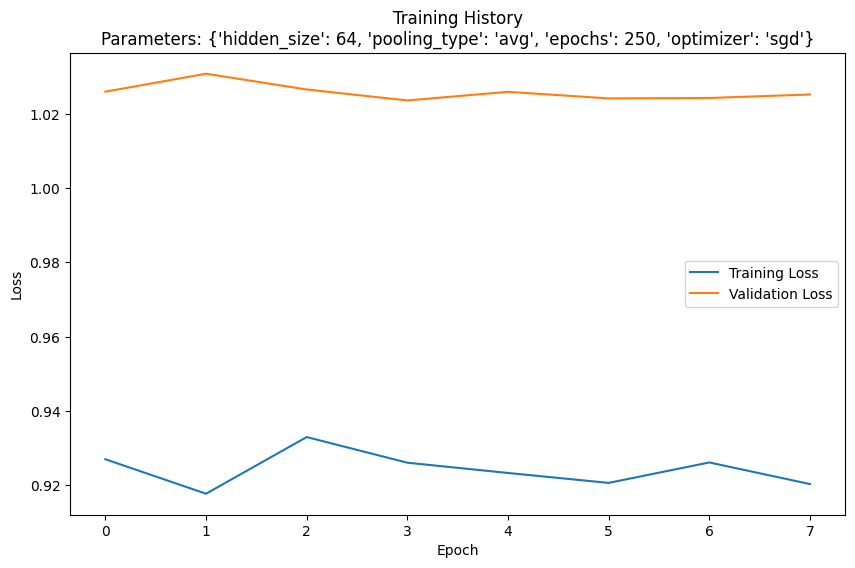


Training BiRNN with:
Hidden Size: 64, Pooling: avg
Epochs: 250, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9430, Val Loss = 1.0206
Early stopping triggered at epoch 7


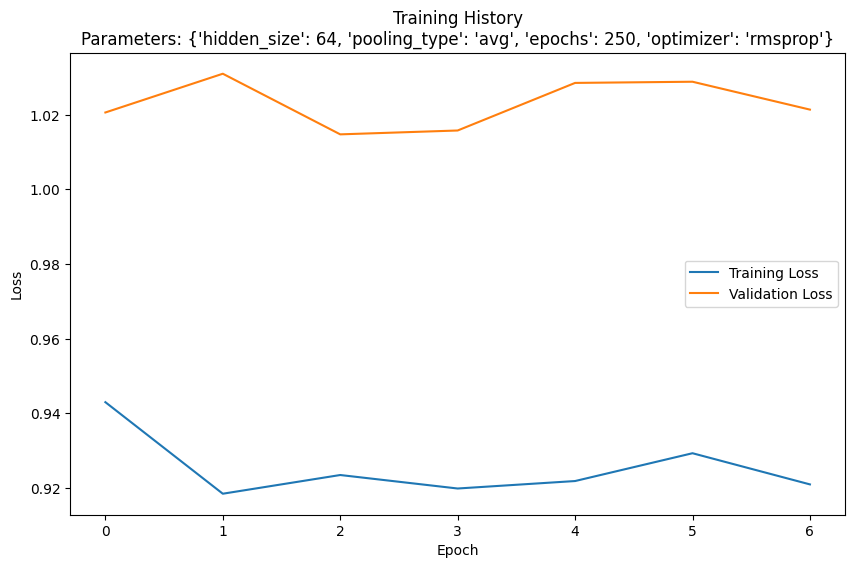


Training BiRNN with:
Hidden Size: 64, Pooling: avg
Epochs: 250, Optimizer: adam
Epoch 0: Train Loss = 0.9248, Val Loss = 1.0228
Early stopping triggered at epoch 9


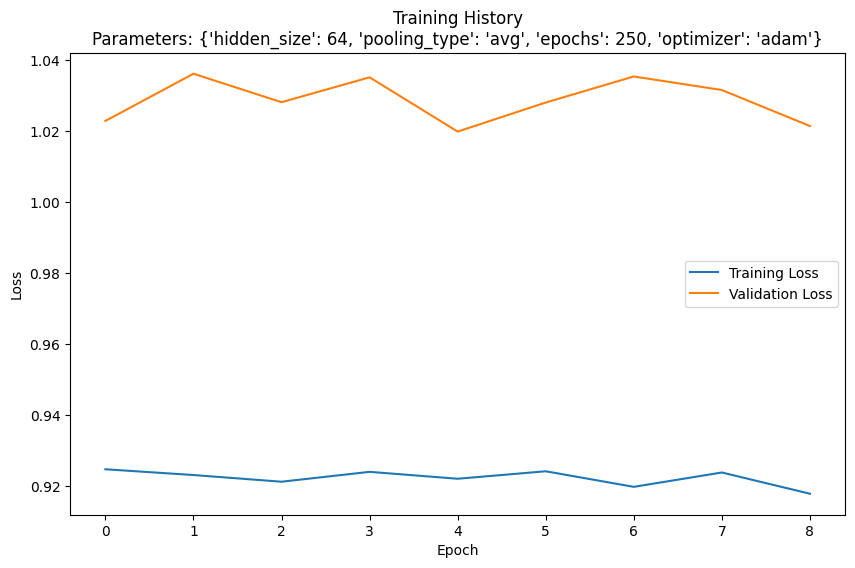


Training BiRNN with:
Hidden Size: 64, Pooling: avg
Epochs: 350, Optimizer: sgd
Epoch 0: Train Loss = 0.9255, Val Loss = 1.0239
Early stopping triggered at epoch 9


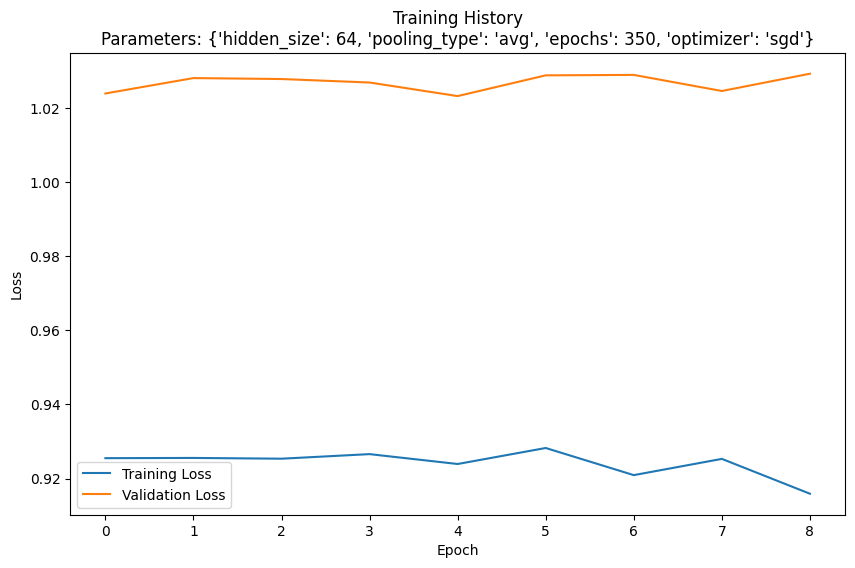


Training BiRNN with:
Hidden Size: 64, Pooling: avg
Epochs: 350, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9360, Val Loss = 1.0458
Early stopping triggered at epoch 7


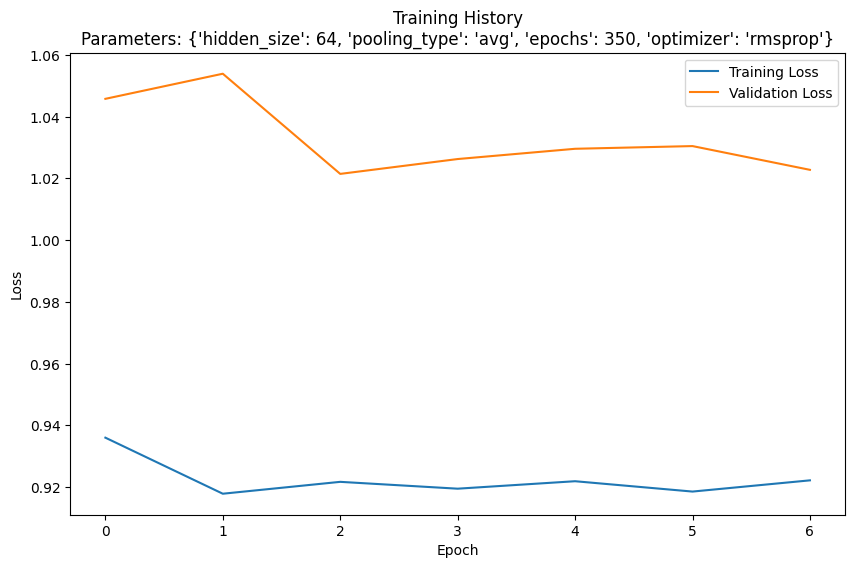


Training BiRNN with:
Hidden Size: 64, Pooling: avg
Epochs: 350, Optimizer: adam
Epoch 0: Train Loss = 0.9288, Val Loss = 1.0203
Early stopping triggered at epoch 5


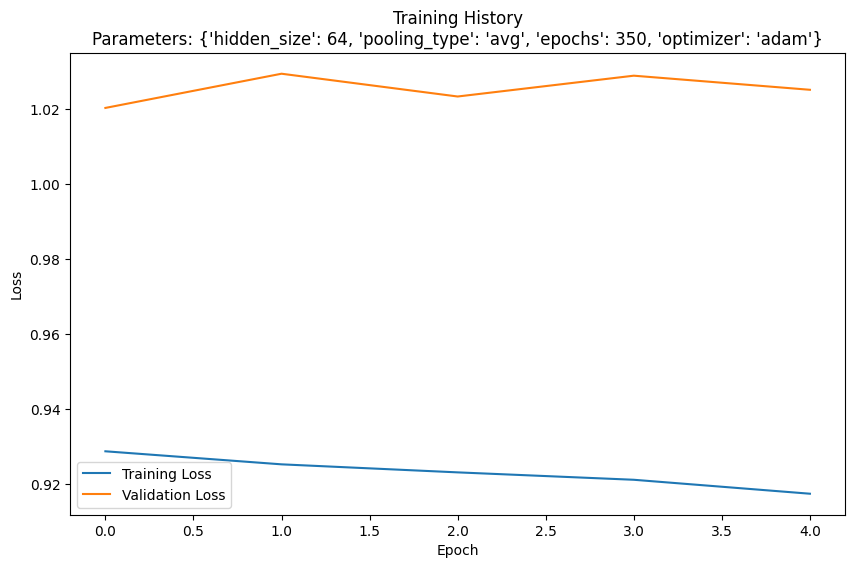


Training BiRNN with:
Hidden Size: 128, Pooling: max
Epochs: 5, Optimizer: sgd
Epoch 0: Train Loss = 0.9545, Val Loss = 1.0170


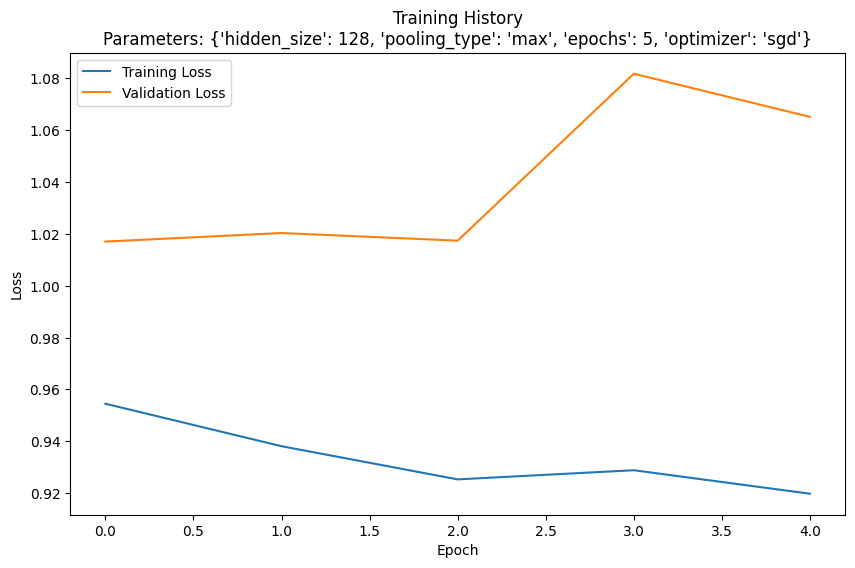


Training BiRNN with:
Hidden Size: 128, Pooling: max
Epochs: 5, Optimizer: rmsprop
Epoch 0: Train Loss = 1.0500, Val Loss = 1.0246


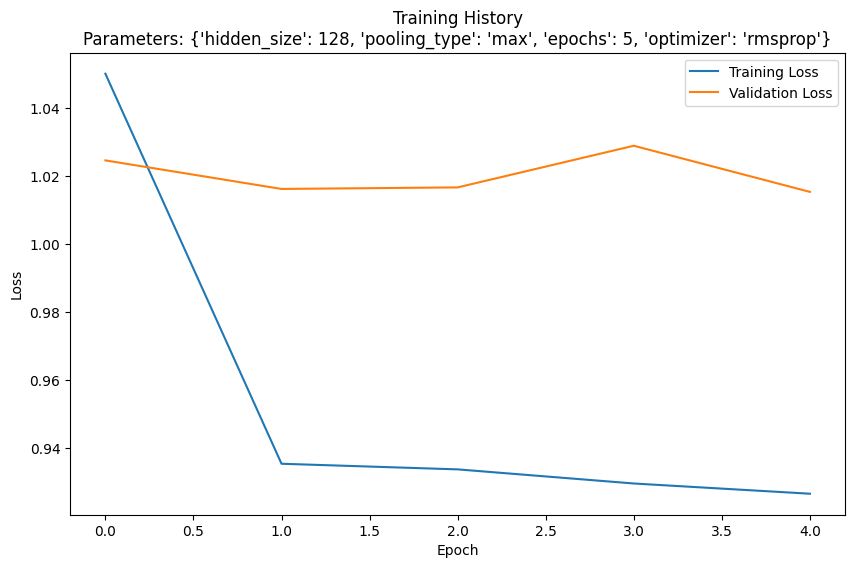


Training BiRNN with:
Hidden Size: 128, Pooling: max
Epochs: 5, Optimizer: adam
Epoch 0: Train Loss = 0.9288, Val Loss = 1.0172


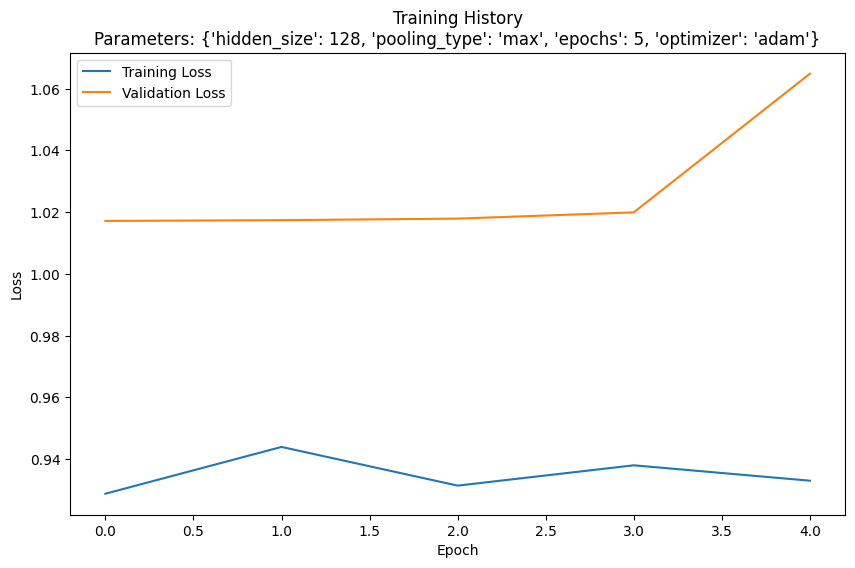


Training BiRNN with:
Hidden Size: 128, Pooling: max
Epochs: 50, Optimizer: sgd
Epoch 0: Train Loss = 0.9364, Val Loss = 1.0177
Early stopping triggered at epoch 5


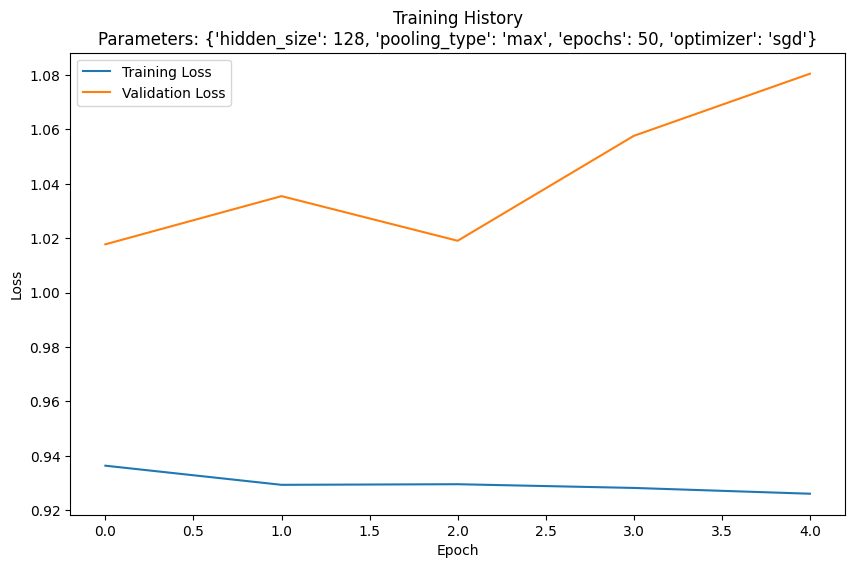


Training BiRNN with:
Hidden Size: 128, Pooling: max
Epochs: 50, Optimizer: rmsprop
Epoch 0: Train Loss = 1.0785, Val Loss = 1.0585
Epoch 10: Train Loss = 0.9295, Val Loss = 1.0219
Early stopping triggered at epoch 13


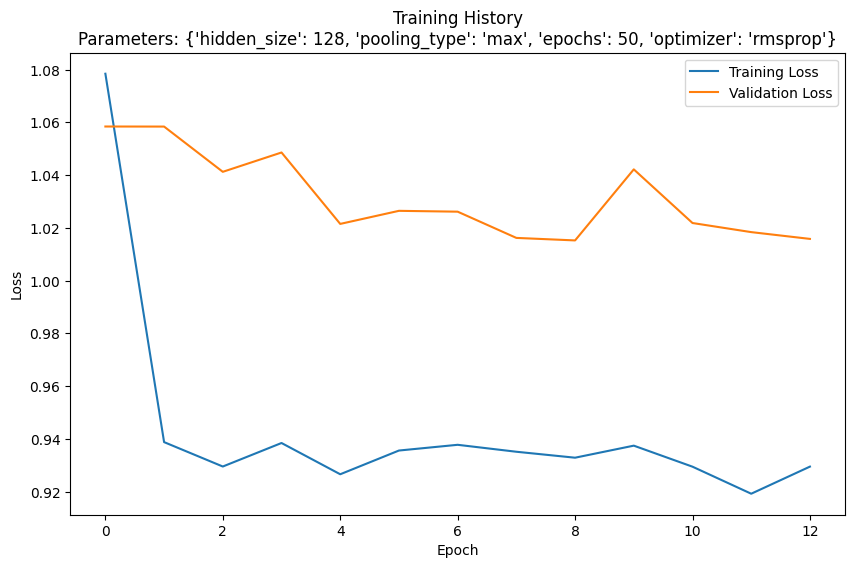


Training BiRNN with:
Hidden Size: 128, Pooling: max
Epochs: 50, Optimizer: adam
Epoch 0: Train Loss = 0.9421, Val Loss = 1.0559
Early stopping triggered at epoch 10


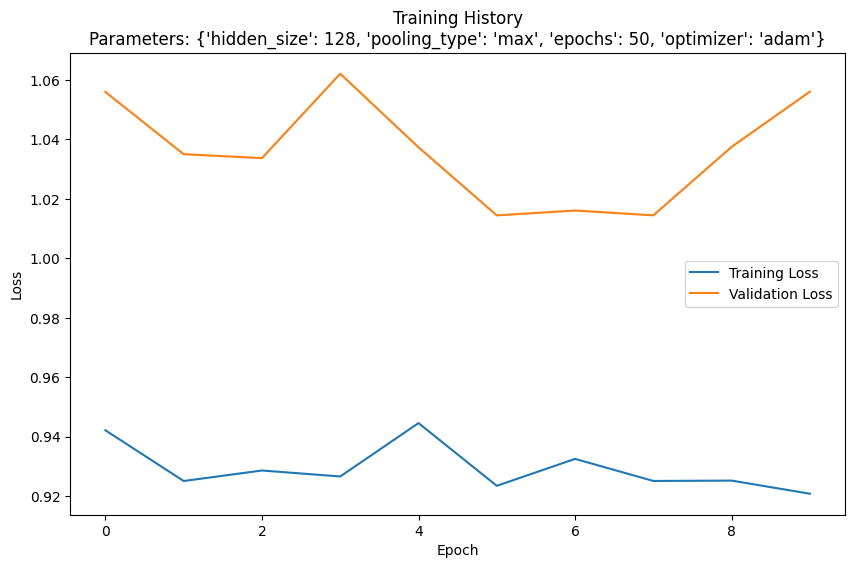


Training BiRNN with:
Hidden Size: 128, Pooling: max
Epochs: 100, Optimizer: sgd
Epoch 0: Train Loss = 0.9307, Val Loss = 1.0202
Early stopping triggered at epoch 6


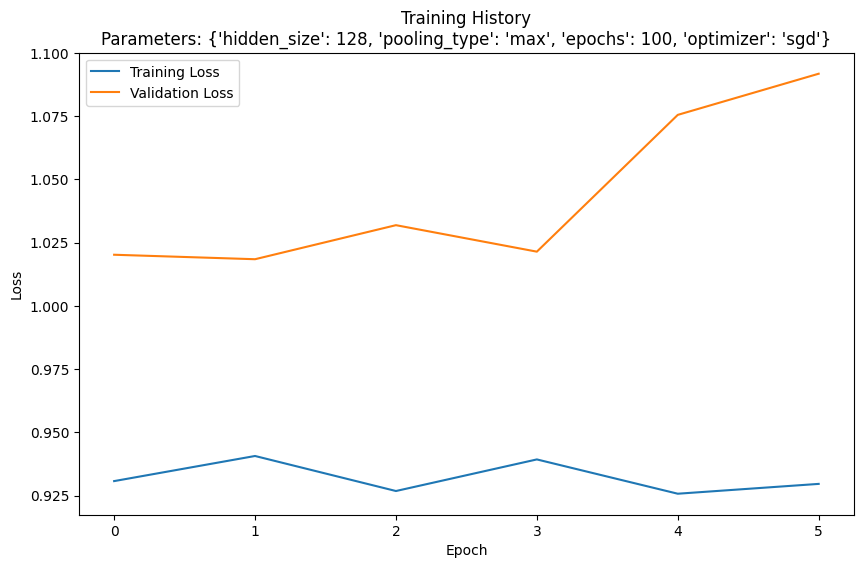


Training BiRNN with:
Hidden Size: 128, Pooling: max
Epochs: 100, Optimizer: rmsprop
Epoch 0: Train Loss = 1.0621, Val Loss = 1.0250
Early stopping triggered at epoch 9


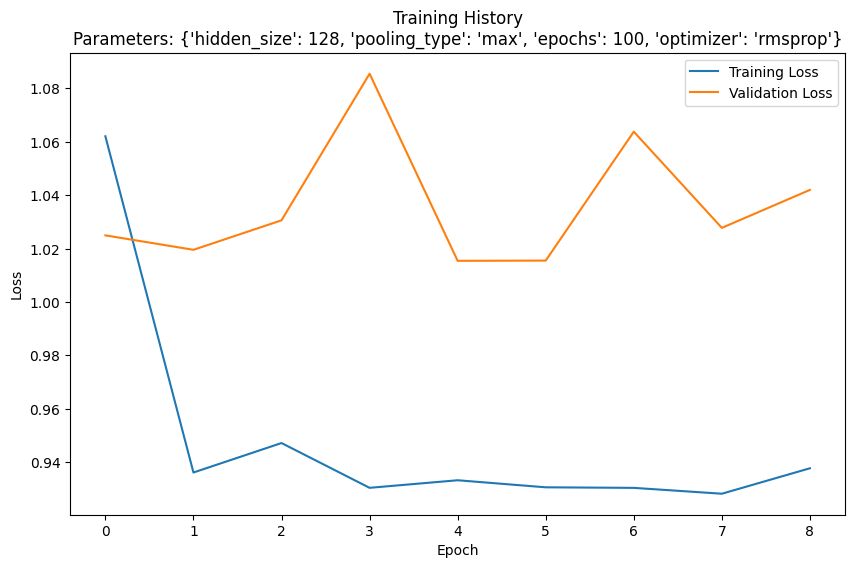


Training BiRNN with:
Hidden Size: 128, Pooling: max
Epochs: 100, Optimizer: adam
Epoch 0: Train Loss = 0.9337, Val Loss = 1.0676
Early stopping triggered at epoch 6


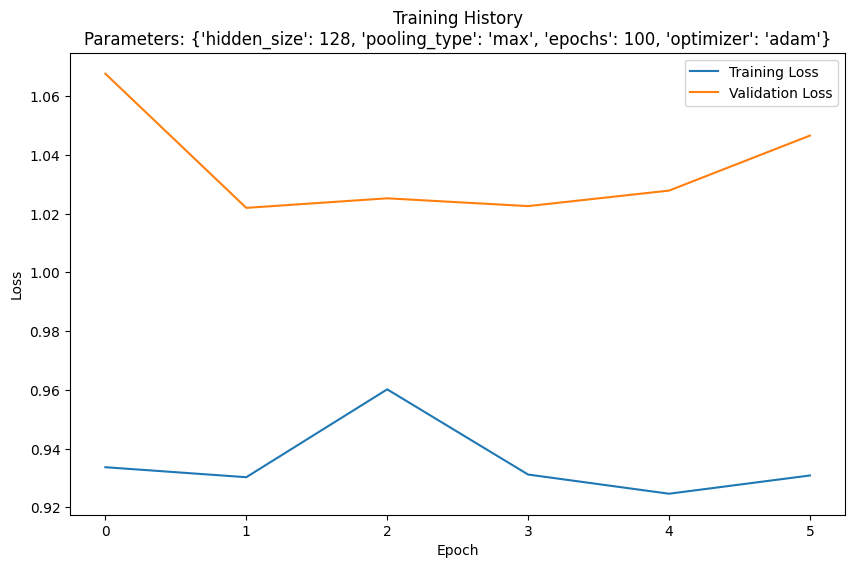


Training BiRNN with:
Hidden Size: 128, Pooling: max
Epochs: 250, Optimizer: sgd
Epoch 0: Train Loss = 0.9356, Val Loss = 1.0198
Early stopping triggered at epoch 8


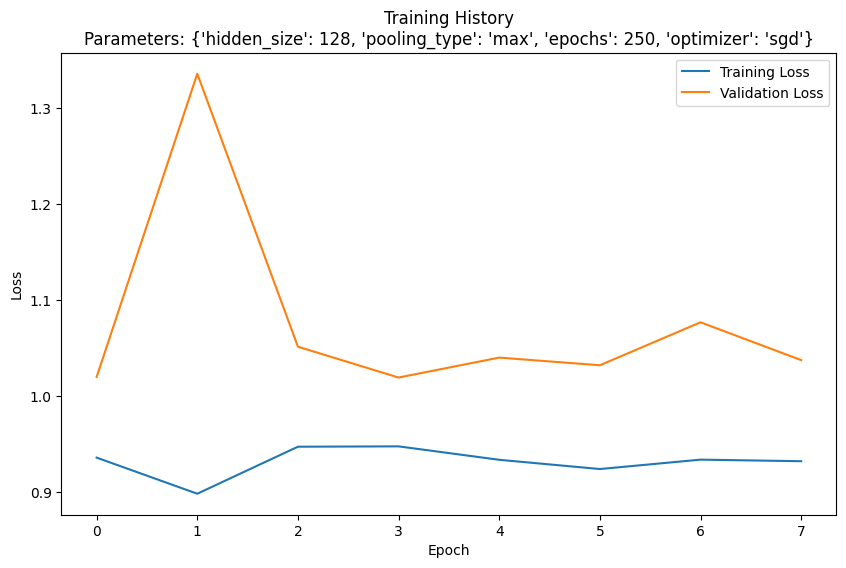


Training BiRNN with:
Hidden Size: 128, Pooling: max
Epochs: 250, Optimizer: rmsprop
Epoch 0: Train Loss = 1.0599, Val Loss = 1.0789
Epoch 10: Train Loss = 0.9378, Val Loss = 1.0358
Early stopping triggered at epoch 11


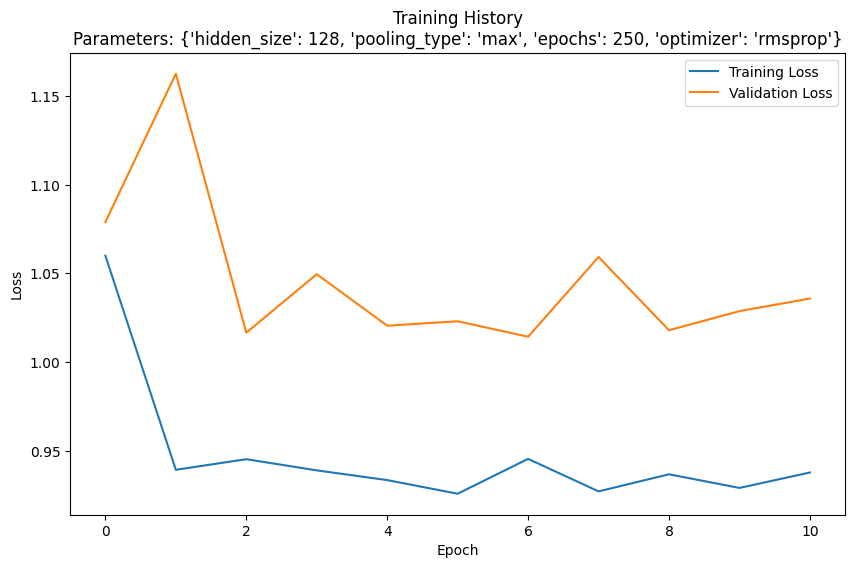


Training BiRNN with:
Hidden Size: 128, Pooling: max
Epochs: 250, Optimizer: adam
Epoch 0: Train Loss = 0.9394, Val Loss = 1.0222
Early stopping triggered at epoch 5


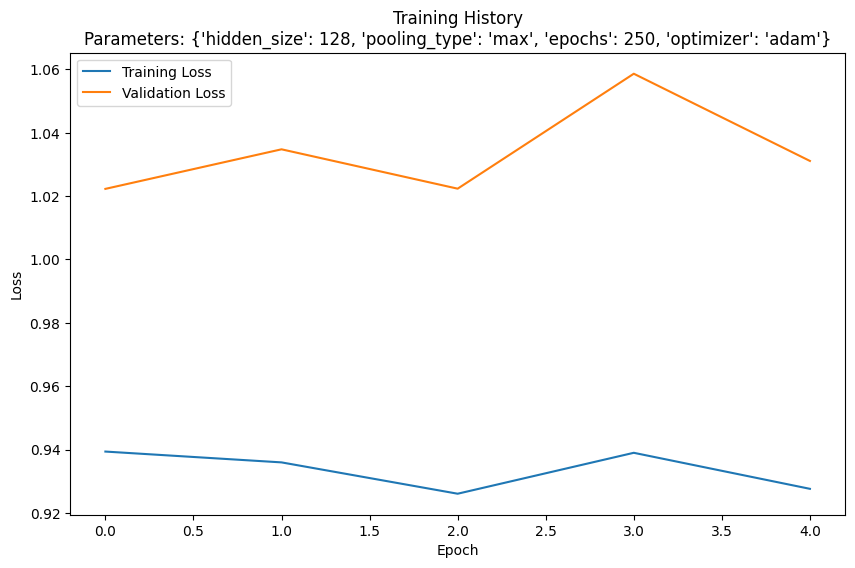


Training BiRNN with:
Hidden Size: 128, Pooling: max
Epochs: 350, Optimizer: sgd
Epoch 0: Train Loss = 0.9347, Val Loss = 1.0532
Epoch 10: Train Loss = 0.9354, Val Loss = 1.0222
Early stopping triggered at epoch 11


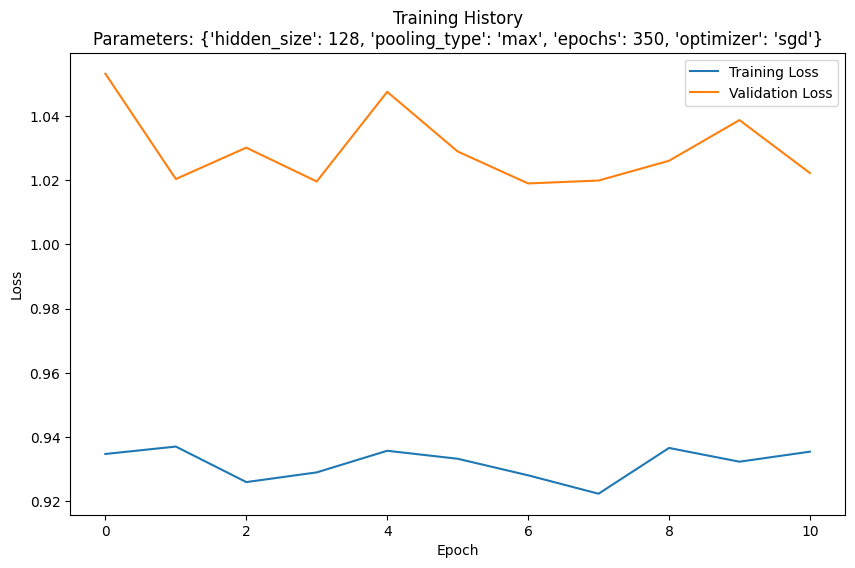


Training BiRNN with:
Hidden Size: 128, Pooling: max
Epochs: 350, Optimizer: rmsprop
Epoch 0: Train Loss = 1.1046, Val Loss = 1.0621
Early stopping triggered at epoch 7


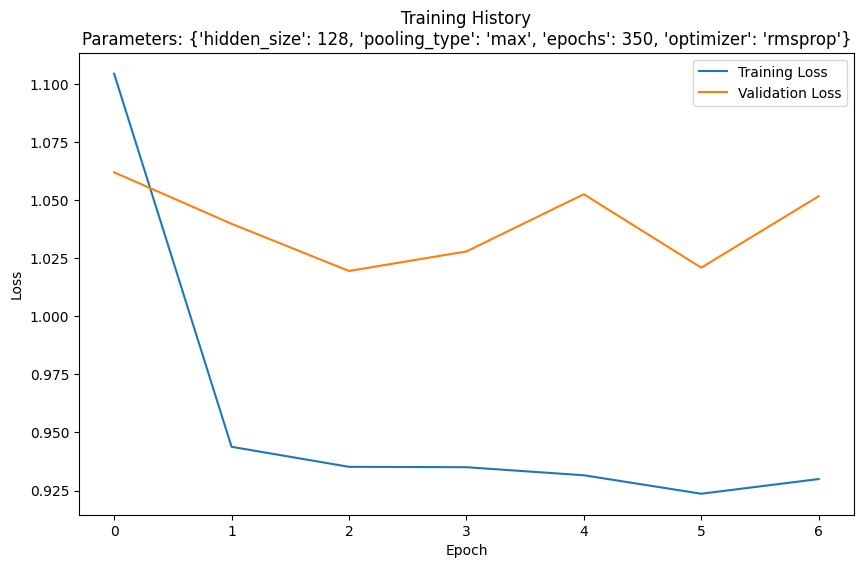


Training BiRNN with:
Hidden Size: 128, Pooling: max
Epochs: 350, Optimizer: adam
Epoch 0: Train Loss = 0.9386, Val Loss = 1.0541
Early stopping triggered at epoch 8


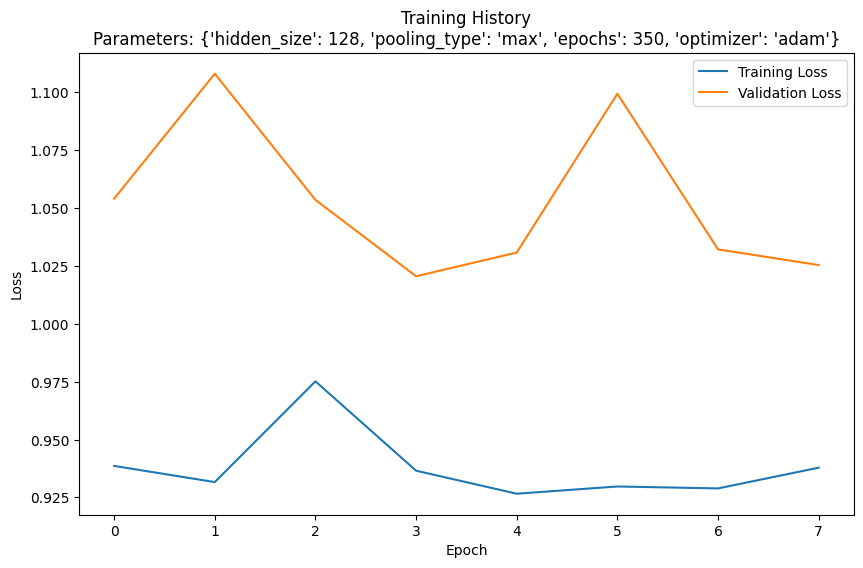


Training BiRNN with:
Hidden Size: 128, Pooling: avg
Epochs: 5, Optimizer: sgd
Epoch 0: Train Loss = 0.9243, Val Loss = 1.0237


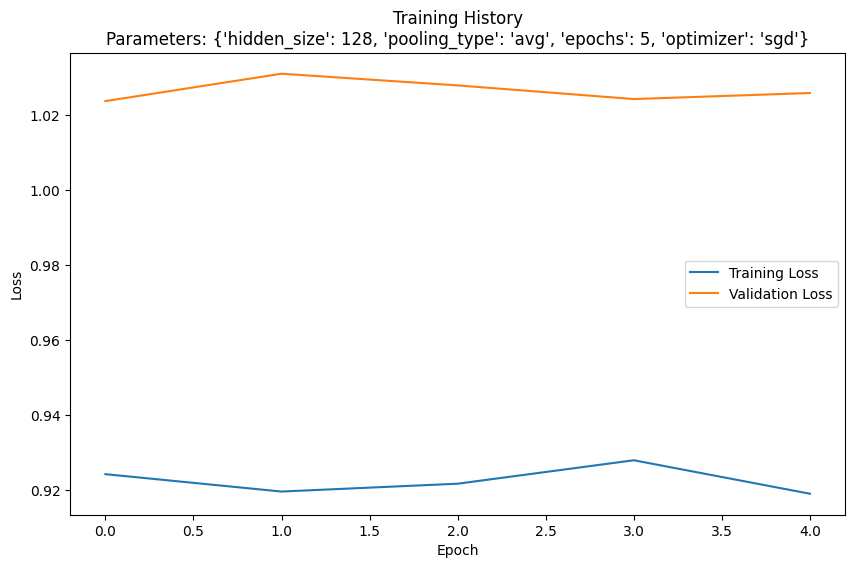


Training BiRNN with:
Hidden Size: 128, Pooling: avg
Epochs: 5, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9547, Val Loss = 1.0260


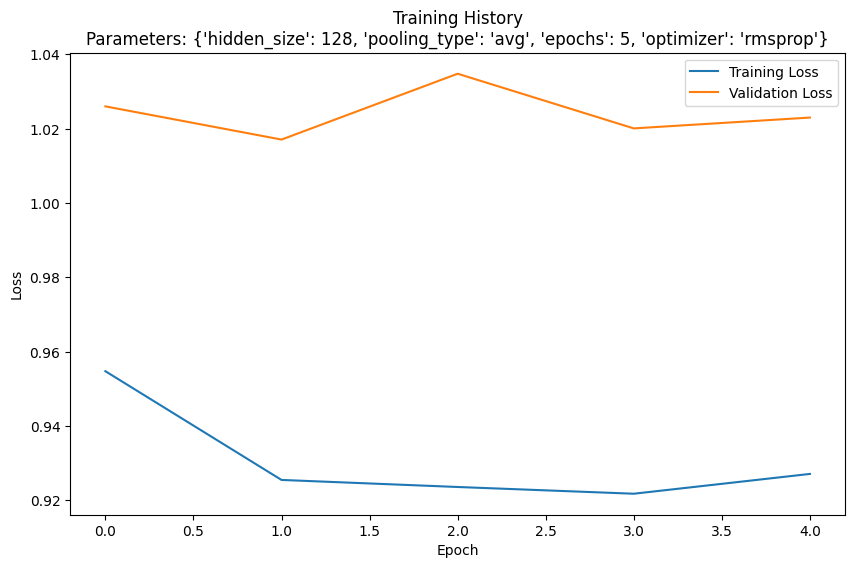


Training BiRNN with:
Hidden Size: 128, Pooling: avg
Epochs: 5, Optimizer: adam
Epoch 0: Train Loss = 0.9383, Val Loss = 1.0172


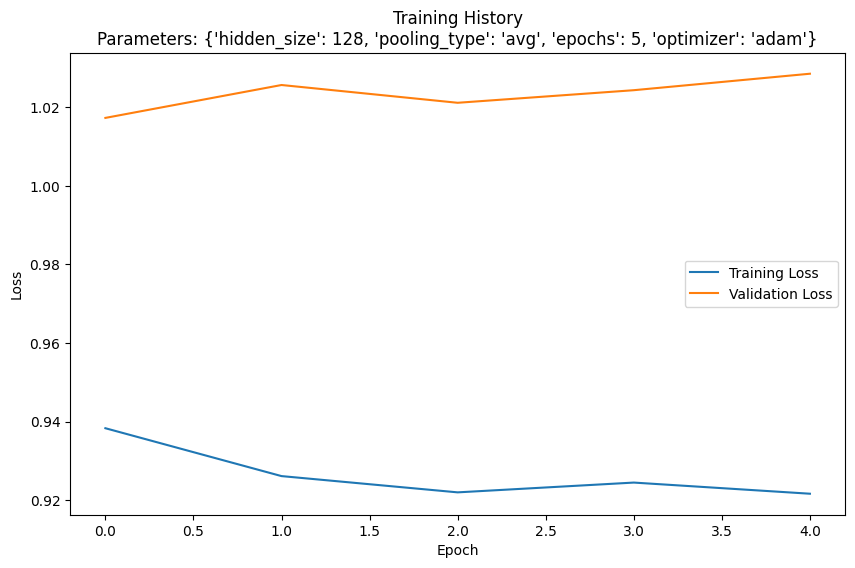


Training BiRNN with:
Hidden Size: 128, Pooling: avg
Epochs: 50, Optimizer: sgd
Epoch 0: Train Loss = 0.9331, Val Loss = 1.0248
Early stopping triggered at epoch 10


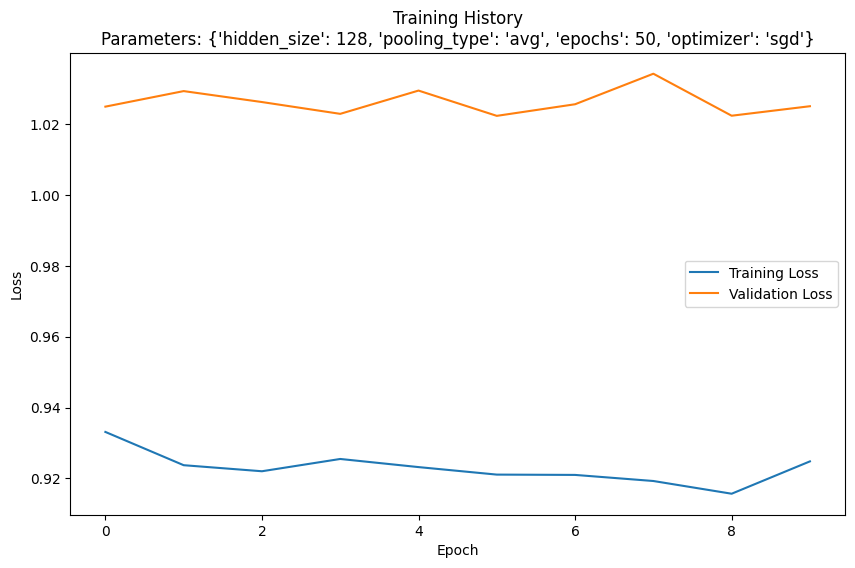


Training BiRNN with:
Hidden Size: 128, Pooling: avg
Epochs: 50, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9579, Val Loss = 1.0361
Early stopping triggered at epoch 9


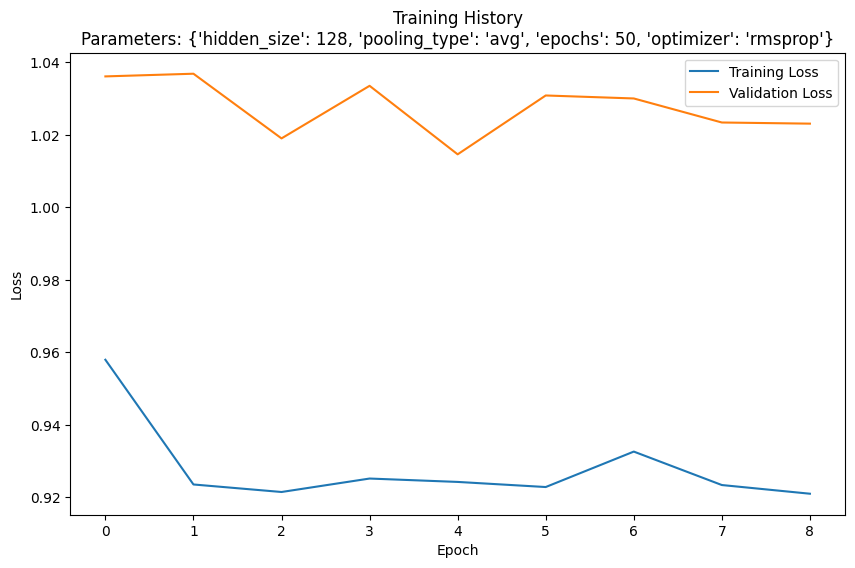


Training BiRNN with:
Hidden Size: 128, Pooling: avg
Epochs: 50, Optimizer: adam
Epoch 0: Train Loss = 0.9280, Val Loss = 1.0195
Early stopping triggered at epoch 6


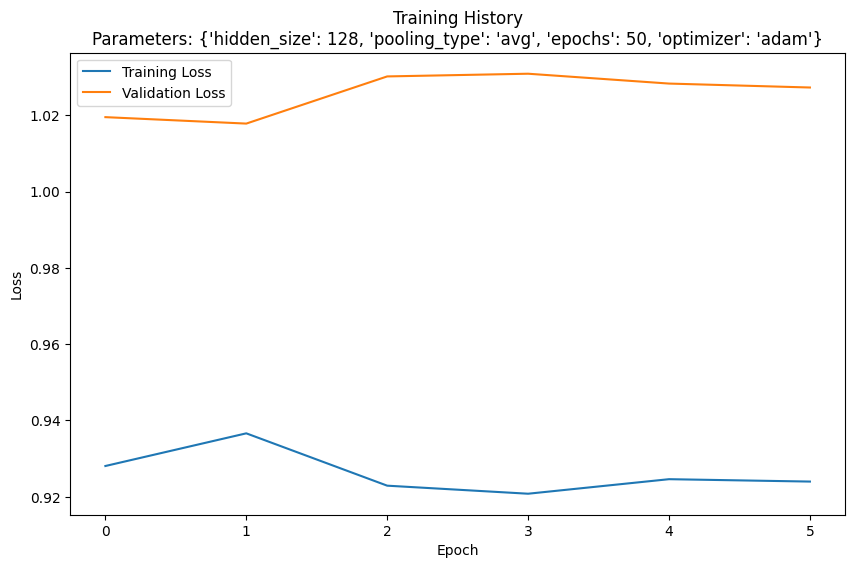


Training BiRNN with:
Hidden Size: 128, Pooling: avg
Epochs: 100, Optimizer: sgd
Epoch 0: Train Loss = 0.9212, Val Loss = 1.0257
Early stopping triggered at epoch 5


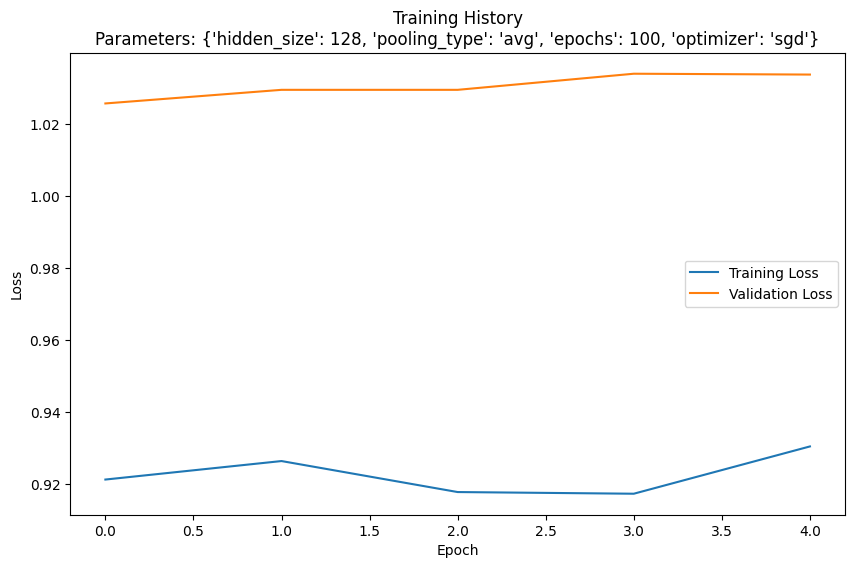


Training BiRNN with:
Hidden Size: 128, Pooling: avg
Epochs: 100, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9570, Val Loss = 1.0199
Early stopping triggered at epoch 5


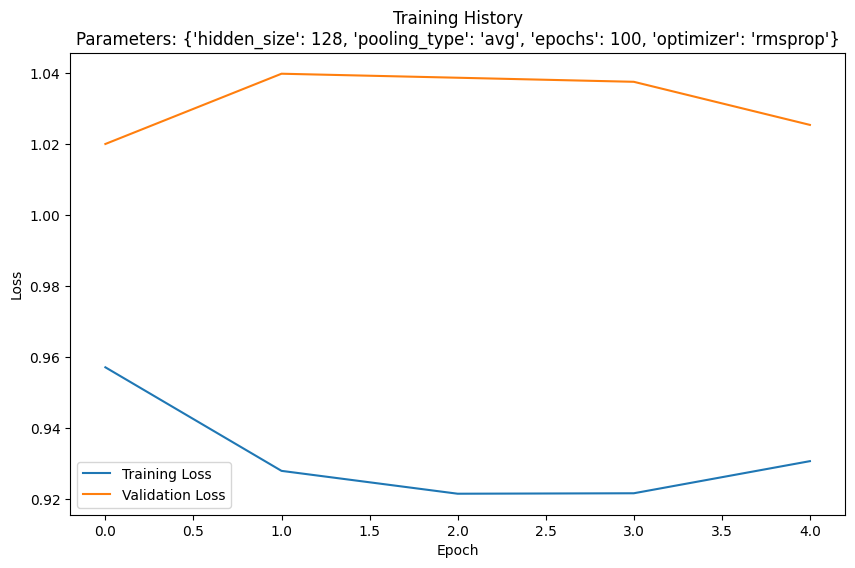


Training BiRNN with:
Hidden Size: 128, Pooling: avg
Epochs: 100, Optimizer: adam
Epoch 0: Train Loss = 0.9312, Val Loss = 1.0380
Early stopping triggered at epoch 10


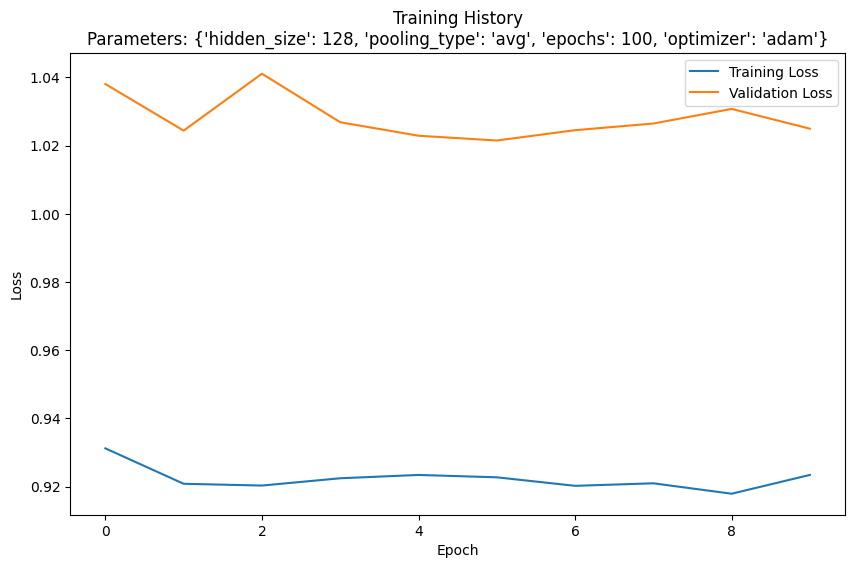


Training BiRNN with:
Hidden Size: 128, Pooling: avg
Epochs: 250, Optimizer: sgd
Epoch 0: Train Loss = 0.9202, Val Loss = 1.0199
Early stopping triggered at epoch 5


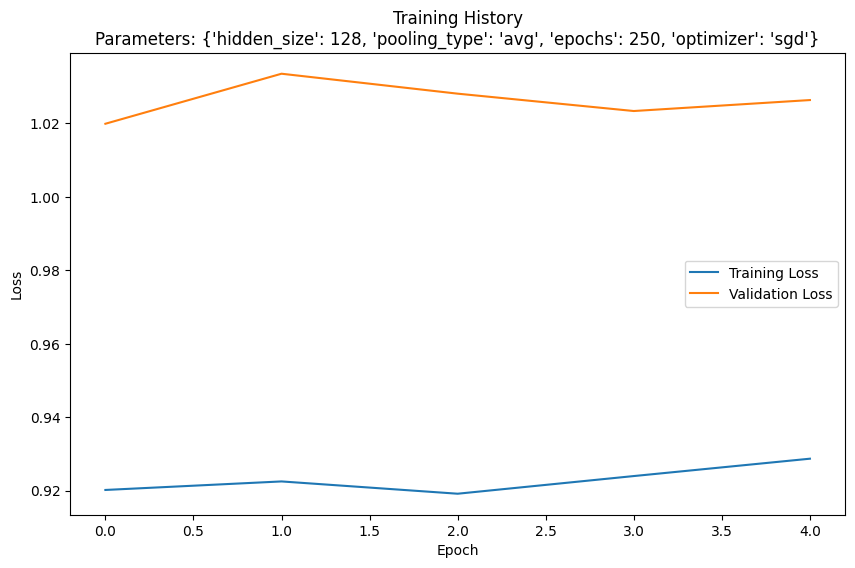


Training BiRNN with:
Hidden Size: 128, Pooling: avg
Epochs: 250, Optimizer: rmsprop
Epoch 0: Train Loss = 1.0241, Val Loss = 1.0210
Early stopping triggered at epoch 9


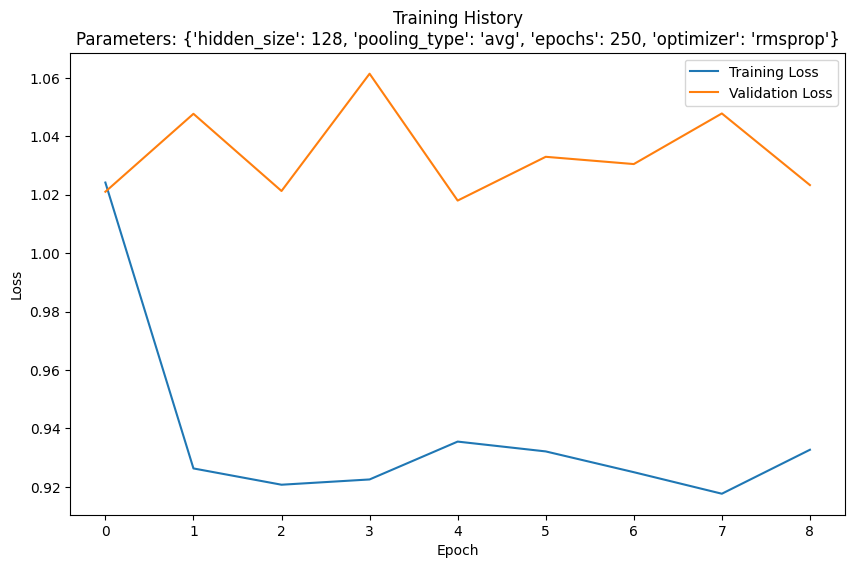


Training BiRNN with:
Hidden Size: 128, Pooling: avg
Epochs: 250, Optimizer: adam
Epoch 0: Train Loss = 0.9264, Val Loss = 1.0334
Early stopping triggered at epoch 8


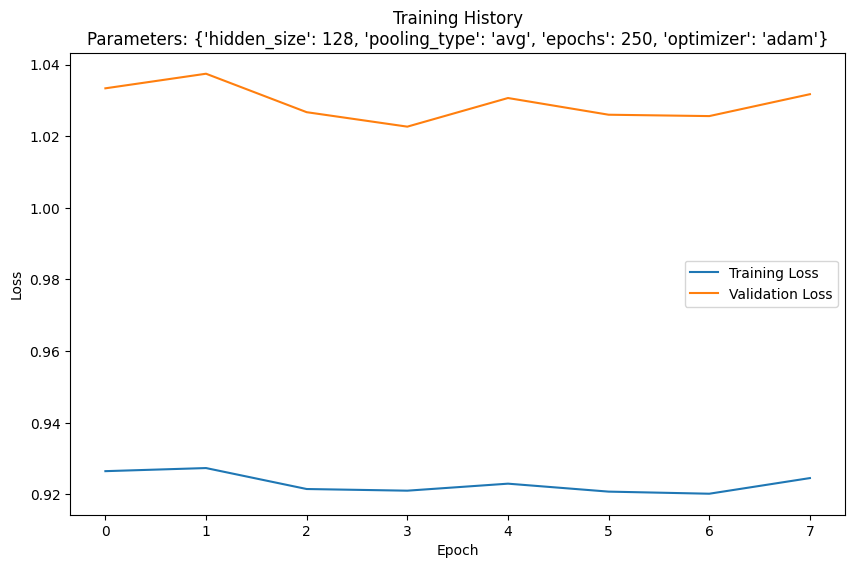


Training BiRNN with:
Hidden Size: 128, Pooling: avg
Epochs: 350, Optimizer: sgd
Epoch 0: Train Loss = 0.9216, Val Loss = 1.0284
Epoch 10: Train Loss = 0.9217, Val Loss = 1.0222
Early stopping triggered at epoch 15


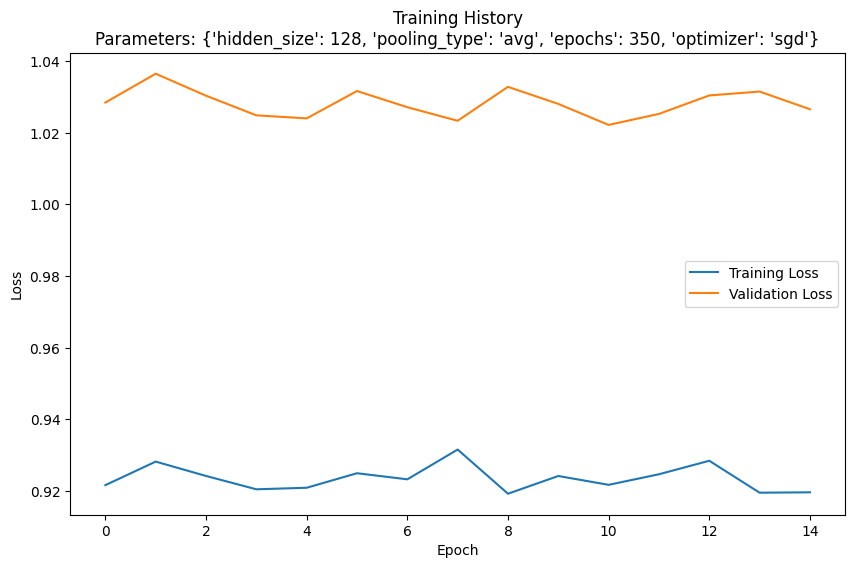


Training BiRNN with:
Hidden Size: 128, Pooling: avg
Epochs: 350, Optimizer: rmsprop
Epoch 0: Train Loss = 0.9376, Val Loss = 1.0217
Early stopping triggered at epoch 7


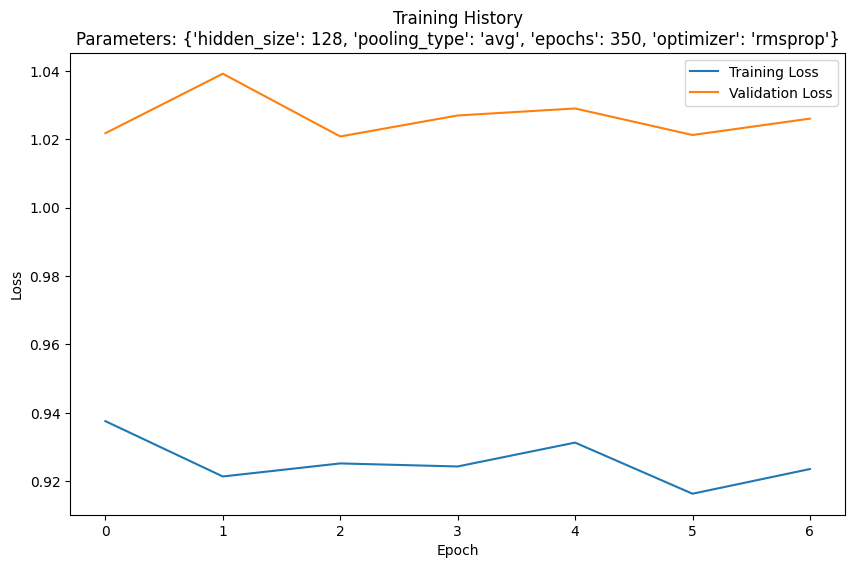


Training BiRNN with:
Hidden Size: 128, Pooling: avg
Epochs: 350, Optimizer: adam
Epoch 0: Train Loss = 0.9364, Val Loss = 1.0503
Early stopping triggered at epoch 7


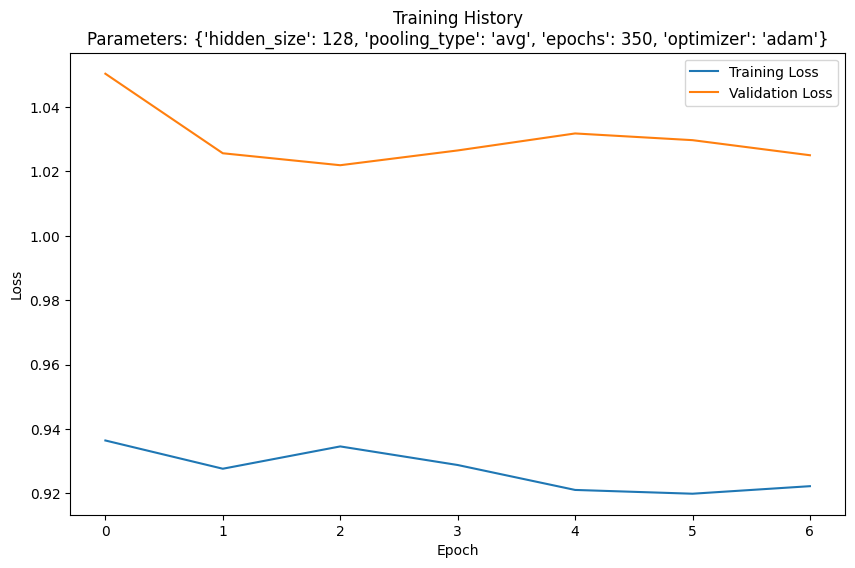


Best Configuration:
hidden_size: 64
pooling_type: max
epochs: 250
optimizer: sgd
final_train_loss: 0.9310319566726685
final_val_loss: 1.0156256059805553
best_val_loss: 1.0126445194085438


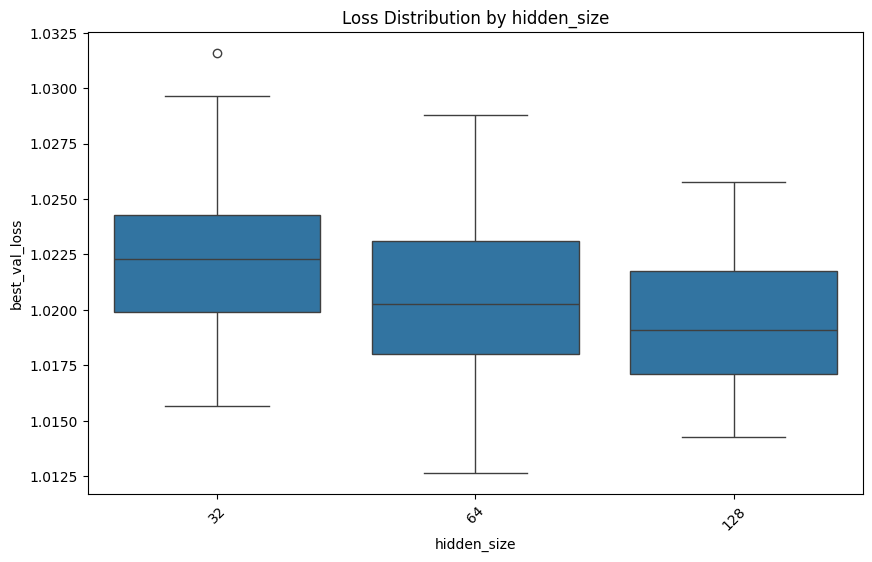


Analysis by hidden_size:
                 mean       std       min       max
hidden_size                                        
32           1.022257  0.003856  1.015668  1.031589
64           1.020323  0.003535  1.012645  1.028769
128          1.019085  0.003017  1.014261  1.025750


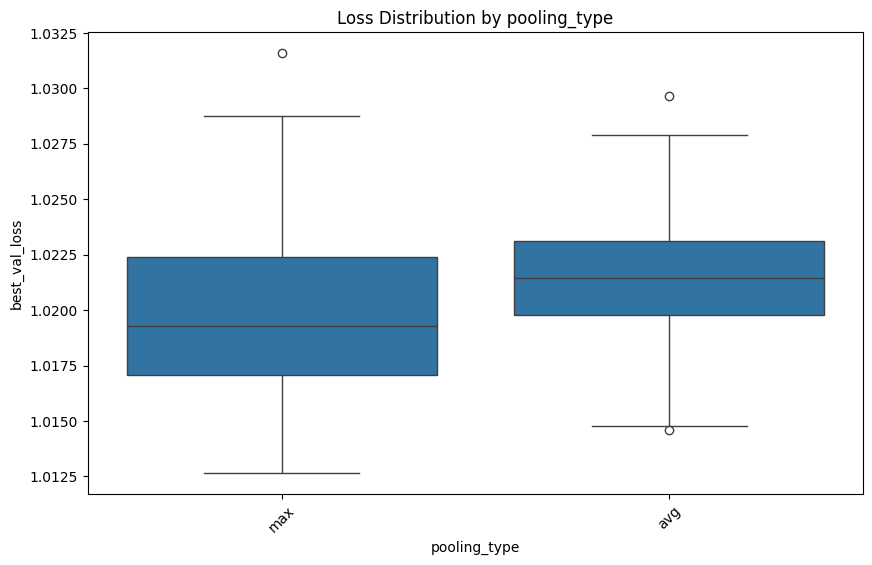


Analysis by pooling_type:
                  mean       std       min       max
pooling_type                                        
avg           1.021059  0.003209  1.014588  1.029651
max           1.020051  0.004087  1.012645  1.031589


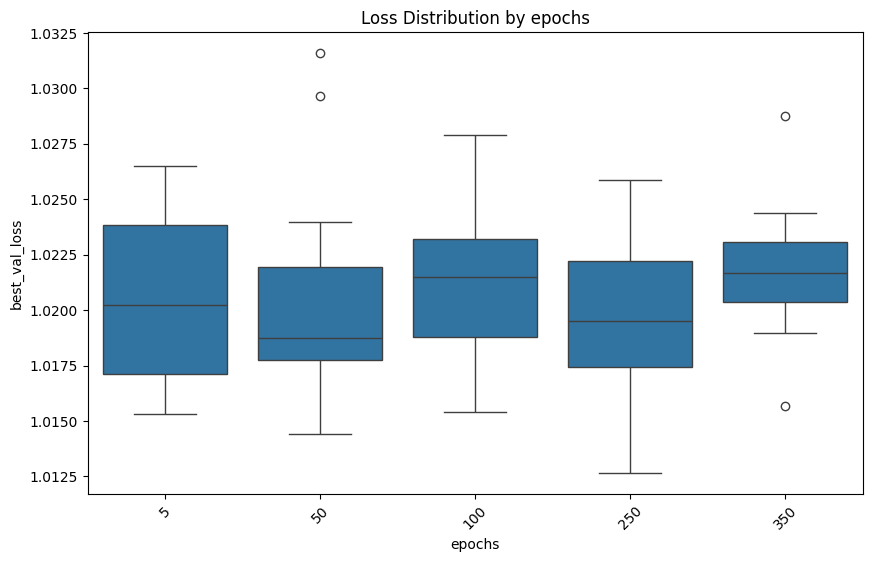


Analysis by epochs:
            mean       std       min       max
epochs                                        
5       1.020368  0.003640  1.015299  1.026516
50      1.020051  0.004722  1.014408  1.031589
100     1.021081  0.003431  1.015421  1.027887
250     1.019533  0.003685  1.012645  1.025879
350     1.021742  0.002670  1.015668  1.028769


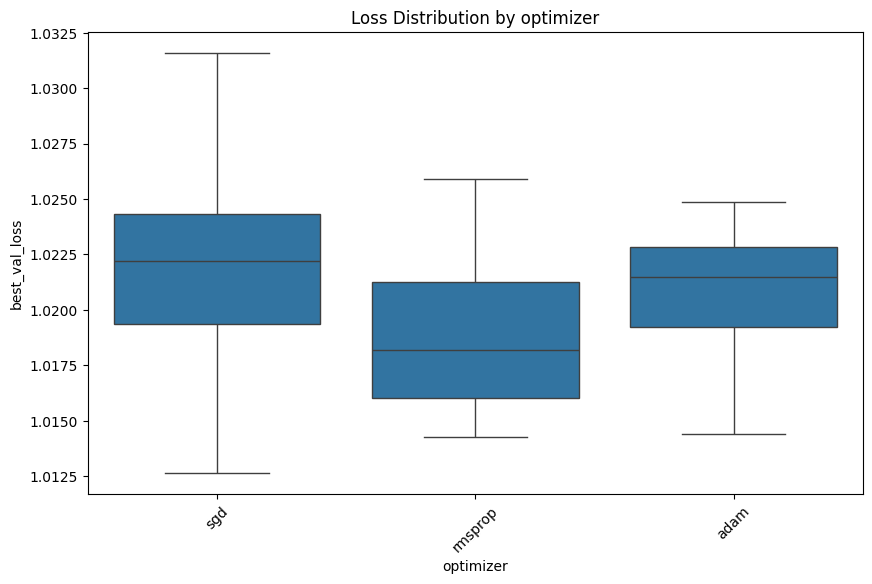


Analysis by optimizer:
               mean       std       min       max
optimizer                                        
adam       1.020818  0.002809  1.014408  1.024876
rmsprop    1.018644  0.003172  1.014261  1.025879
sgd        1.022203  0.004141  1.012645  1.031589

Results saved to 'bank.csv'


In [16]:
if __name__ == "__main__":
    main()